# ___Problem Statement___
## _Business Problem Overview_
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

# ___Importing key libraries___

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import re
import os

import missingno as msno

from sklearn.model_selection import train_test_split # Train Test Split 
from sklearn.experimental import enable_iterative_imputer  # Needed to enable IterativeImputer
from sklearn.impute import IterativeImputer # For Imputing Null Values 
from sklearn.linear_model import LogisticRegression # Initial Model
from sklearn.preprocessing import MinMaxScaler, PowerTransformer # Scaling the Data
from sklearn.ensemble import RandomForestClassifier # Finding the Important Features
from sklearn.tree import DecisionTreeClassifier  # Base estimator for AdaBoost
from sklearn.ensemble import AdaBoostClassifier # AdaBoost Classifier
from sklearn.decomposition import PCA # Principal Component Analysis
from sklearn.decomposition import IncrementalPCA # `Incremental PCA` is useful for large datasets
from imblearn.pipeline import Pipeline # `Pipeline` is useful for chaining the operations
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV # Grid Search CV
from imblearn.combine  import SMOTETomek # `SMOTETomek` is used for Oversampling
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score 
# `metrics` are used for evaluation

import matplotlib as mpl # For customizing the colors
import matplotlib.pyplot as plt # For Plots

import statsmodels.api as sm # For finding the p-values

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# ___Assiging the Dataset to the .csv files___

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input/telecom-churn-datasets'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# We can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# We can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Using Pandas to Load and Read the Data
data_dictionary = pd.read_csv('data_dictionary.csv')
test_df = pd.read_csv('train.csv')
unseen_df = pd.read_csv('test.csv')

In [4]:
# Displaying the size and shape of the data
print(data_dictionary.shape)
print(test_df.shape)
print(unseen_df.shape)

(36, 2)
(69999, 172)
(30000, 171)


# ___Understanding the data___

In [ ]:
# Displaying the dictionary to understnad the data better 
data_dictionary

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [6]:
test_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [7]:
test_df.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [8]:
unseen_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [9]:
print(test_df.columns)

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)


# ___Generating new coulumns___
___Consider the data acroms and finding the most sutaible combination___

In [10]:
# Identifying key variables based on descriptions
ids = ['id', 'circle_id']

# Adding revenue and amount-related variables
total_amounts = [i for i in list(test_df.columns) if re.search('total.+amt', i)]
recharge_amounts = [i for i in list(test_df.columns) if re.search('rech.+amt', i)]
vbc_costs = [i for i in list(test_df.columns) if re.search('vbc', i)]
arpu_values = [i for i in list(test_df.columns) if re.search('arpu', i)]

# Call usage variables
total_outgoing_minutes = [i for i in list(test_df.columns) if re.search('total.+og.+mou', i)]
incoming_minutes = [i for i in list(test_df.columns) if re.search('ic.+mou', i)]
roaming_minutes = [i for i in list(test_df.columns) if re.search('roam.+mou', i)]
special_call_minutes = [i for i in list(test_df.columns) if re.search('spl.+mou', i)]
isd_call_minutes = [i for i in list(test_df.columns) if re.search('isd.+mou', i)]

# On-net and off-net variables
onnet_minutes = [i for i in list(test_df.columns) if re.search('onnet.+mou', i)]
offnetwork_minutes = [i for i in list(test_df.columns) if re.search('offnet.+mou', i)]

# Internet usage variables
volume_3g = [i for i in list(test_df.columns) if re.search('vol.+3g', i)]
volume_2g = [i for i in list(test_df.columns) if re.search('vol.+2g', i)]
average_revenue_3g = [i for i in list(test_df.columns) if re.search('arpu.+3g', i)]
average_revenue_2g = [i for i in list(test_df.columns) if re.search('arpu.+2g', i)]

# Age and scheme-related variables
age_on_network = [i for i in list(test_df.columns) if re.search('aon', i)]
night_usage = [i for i in list(test_df.columns) if re.search('night', i)]
monthly_schemes = [i for i in list(test_df.columns) if re.search('monthly', i)]
sachet_schemes = [i for i in list(test_df.columns) if re.search('sachet', i)]
fb_user = [i for i in list(test_df.columns) if re.search('fb_user', i)]

# Call type-specific usage
t2t_calls = [i for i in list(test_df.columns) if re.search('t2t', i)]
t2m_calls = [i for i in list(test_df.columns) if re.search('t2m', i)]
t2o_calls = [i for i in list(test_df.columns) if re.search('t2o', i)]
t2f_calls = [i for i in list(test_df.columns) if re.search('t2f', i)]
t2c_calls = [i for i in list(test_df.columns) if re.search('t2c', i)]

# KPIs for specific months
monthly_kpis = [i for i in list(test_df.columns) if re.search(r'\.\d+', i)]

# Storing them in a single flat list
variables = [
    *ids,
    *total_amounts,
    *recharge_amounts,
    *vbc_costs,
    *arpu_values,
    *total_outgoing_minutes,
    *incoming_minutes,
    *roaming_minutes,
    *special_call_minutes,
    *isd_call_minutes,
    *onnet_minutes,
    *offnetwork_minutes,
    *volume_3g,
    *volume_2g,
    *average_revenue_3g,
    *average_revenue_2g,
    *age_on_network,
    *night_usage,
    *monthly_schemes,
    *sachet_schemes,
    *fb_user,
    *t2t_calls,
    *t2m_calls,
    *t2o_calls,
    *t2f_calls,
    *t2c_calls,
    *monthly_kpis,
    'churn_probability'
]

# Selecting the relevant subset of data
data = test_df[variables].set_index('id')


In [11]:
data.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109                77                65                10   
1         109                 0               145                50   
2         109                70               120                 0   
3         109               160               240               130   
4         109               290               136               122   

    total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
id                                                                         
0                 77                65                10              65   
1                  0               145                50               0   
2                 70               120                 0              70   
3                160               240               130             110   
4                290               136               122              50   

    max_rech_amt_7  max_rech_amt_8  ...  std_ic_t2f_mou_6  std_ic_t2f_mou_7  \
id                                  ...                                       
0               65              10  ...               0.0               0.0   
1              145              50  ...               0.0               0.0   
2               70               0  ...               0.0               0.0   
3              110              50  ...               0.0               0.0   
4               41              30  ...               0.0               0.0   

    std_ic_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                           
0                0.0              0.00              0.00              0.00   
1                0.0              0.00             22.01             29.79   
2                0.0              2.14              0.00              0.00   
3                0.0              0.00              0.00              8.03   
4                0.0              0.00              9.85              0.00   

    std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
id                                                                           
0                0.0               0.0               0.0                  0  
1                0.0               0.0               0.0                  0  
2                0.0               0.0               0.0                  0  
3                0.0               0.0               0.0                  0  
4                0.0               0.0               0.0                  0  

[5 rows x 172 columns]

In [12]:
# Drop duplicate columns based on their headers
data = data.loc[:, ~data.columns.duplicated()]

In [13]:
data.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 132 columns):
 #    Column              Dtype  
---   ------              -----  
 0    circle_id           int64  
 1    total_rech_amt_6    int64  
 2    total_rech_amt_7    int64  
 3    total_rech_amt_8    int64  
 4    max_rech_amt_6      int64  
 5    max_rech_amt_7      int64  
 6    max_rech_amt_8      int64  
 7    av_rech_amt_data_6  float64
 8    av_rech_amt_data_7  float64
 9    av_rech_amt_data_8  float64
 10   aug_vbc_3g          float64
 11   jul_vbc_3g          float64
 12   jun_vbc_3g          float64
 13   arpu_6              float64
 14   arpu_7              float64
 15   arpu_8              float64
 16   arpu_3g_6           float64
 17   arpu_3g_7           float64
 18   arpu_3g_8           float64
 19   arpu_2g_6           float64
 20   arpu_2g_7           float64
 21   arpu_2g_8           float64
 22   total_og_mou_6      float64
 23   total_og_mou_7      float64
 24   total

### New Features and Insights
#### Roaming and Special Call Minutes:
Investigate whether high roaming or special call usage impacts churn.
Analyze user clusters based on roaming and SPL usage.

#### Social Media Scheme (FB_USER):
Determine if social media scheme users churn less due to dependency.
Compare FB_USER adoption rates and churn behavior.

#### Night, Monthly, and Sachet Schemes:
Check if short-term (SACHET) or specific time-based (NIGHT) schemes are more prone to churn.
Conduct a time-series analysis of churn by scheme type.

#### Call Types (T2T, T2M, T2O, etc.):
Analyze whether certain call types (e.g., T2M or T2F) correlate with churn due to cost or quality issues.

#### Monthly KPIs:
Correlate monthly KPIs with churn trends to identify service-level impacts.

In [14]:
data.describe(include='all')

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
count    69999.0      69999.000000      69999.000000      69999.000000   
mean       109.0        328.139788        322.376363        323.846355   
std          0.0        404.211068        411.070120        426.181405   
min        109.0          0.000000          0.000000          0.000000   
25%        109.0        110.000000        100.000000         90.000000   
50%        109.0        229.000000        220.000000        225.000000   
75%        109.0        438.000000        430.000000        436.000000   
max        109.0      35190.000000      40335.000000      45320.000000   

       max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  av_rech_amt_data_6  \
count    69999.000000    69999.000000    69999.000000        17568.000000   
mean       104.569265      104.137573      107.540351          192.831096   
std        121.407701      120.782543      124.396750          190.623115   
min          0.000000        0.000000        0.000000            1.000000   
25%         30.000000       30.000000       30.000000           82.000000   
50%        110.000000      110.000000       98.000000          154.000000   
75%        120.000000      128.000000      144.000000          252.000000   
max       4010.000000     3299.000000     4449.000000         5920.000000   

       av_rech_amt_data_7  av_rech_amt_data_8  ...  std_og_t2f_mou_6  \
count        17865.000000        18417.000000  ...      67231.000000   
mean           201.455940          196.815792  ...          1.126377   
std            198.346141          192.280532  ...          8.136645   
min              1.000000            1.000000  ...          0.000000   
25%             92.000000           84.000000  ...          0.000000   
50%            154.000000          154.000000  ...          0.000000   
75%            252.000000          252.000000  ...          0.000000   
max           4365.000000         4076.000000  ...        628.560000   

       std_og_t2f_mou_7  std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      67312.000000      66296.000000      67231.000000      67312.000000   
mean           1.084062          1.057739          1.126025          1.361052   
std            8.325206          7.696853          5.741811          7.914113   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max          465.790000        354.160000        342.860000        916.240000   

       loc_og_t2c_mou_8  std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  \
count      66296.000000           67231.0           67312.0           66296.0   
mean           1.420840               0.0               0.0               0.0   
std            6.542202               0.0               0.0               0.0   
min            0.000000               0.0               0.0               0.0   
25%            0.000000               0.0               0.0               0.0   
50%            0.000000               0.0               0.0               0.0   
75%            0.000000               0.0               0.0               0.0   
max          351.830000               0.0               0.0               0.0   

       churn_probability  
count       69999.000000  
mean            0.101887  
std             0.302502  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 132 columns]

# ___Handeling Missing Values___

___Analysing the new data for missing values using missingno Library___

<Axes: >

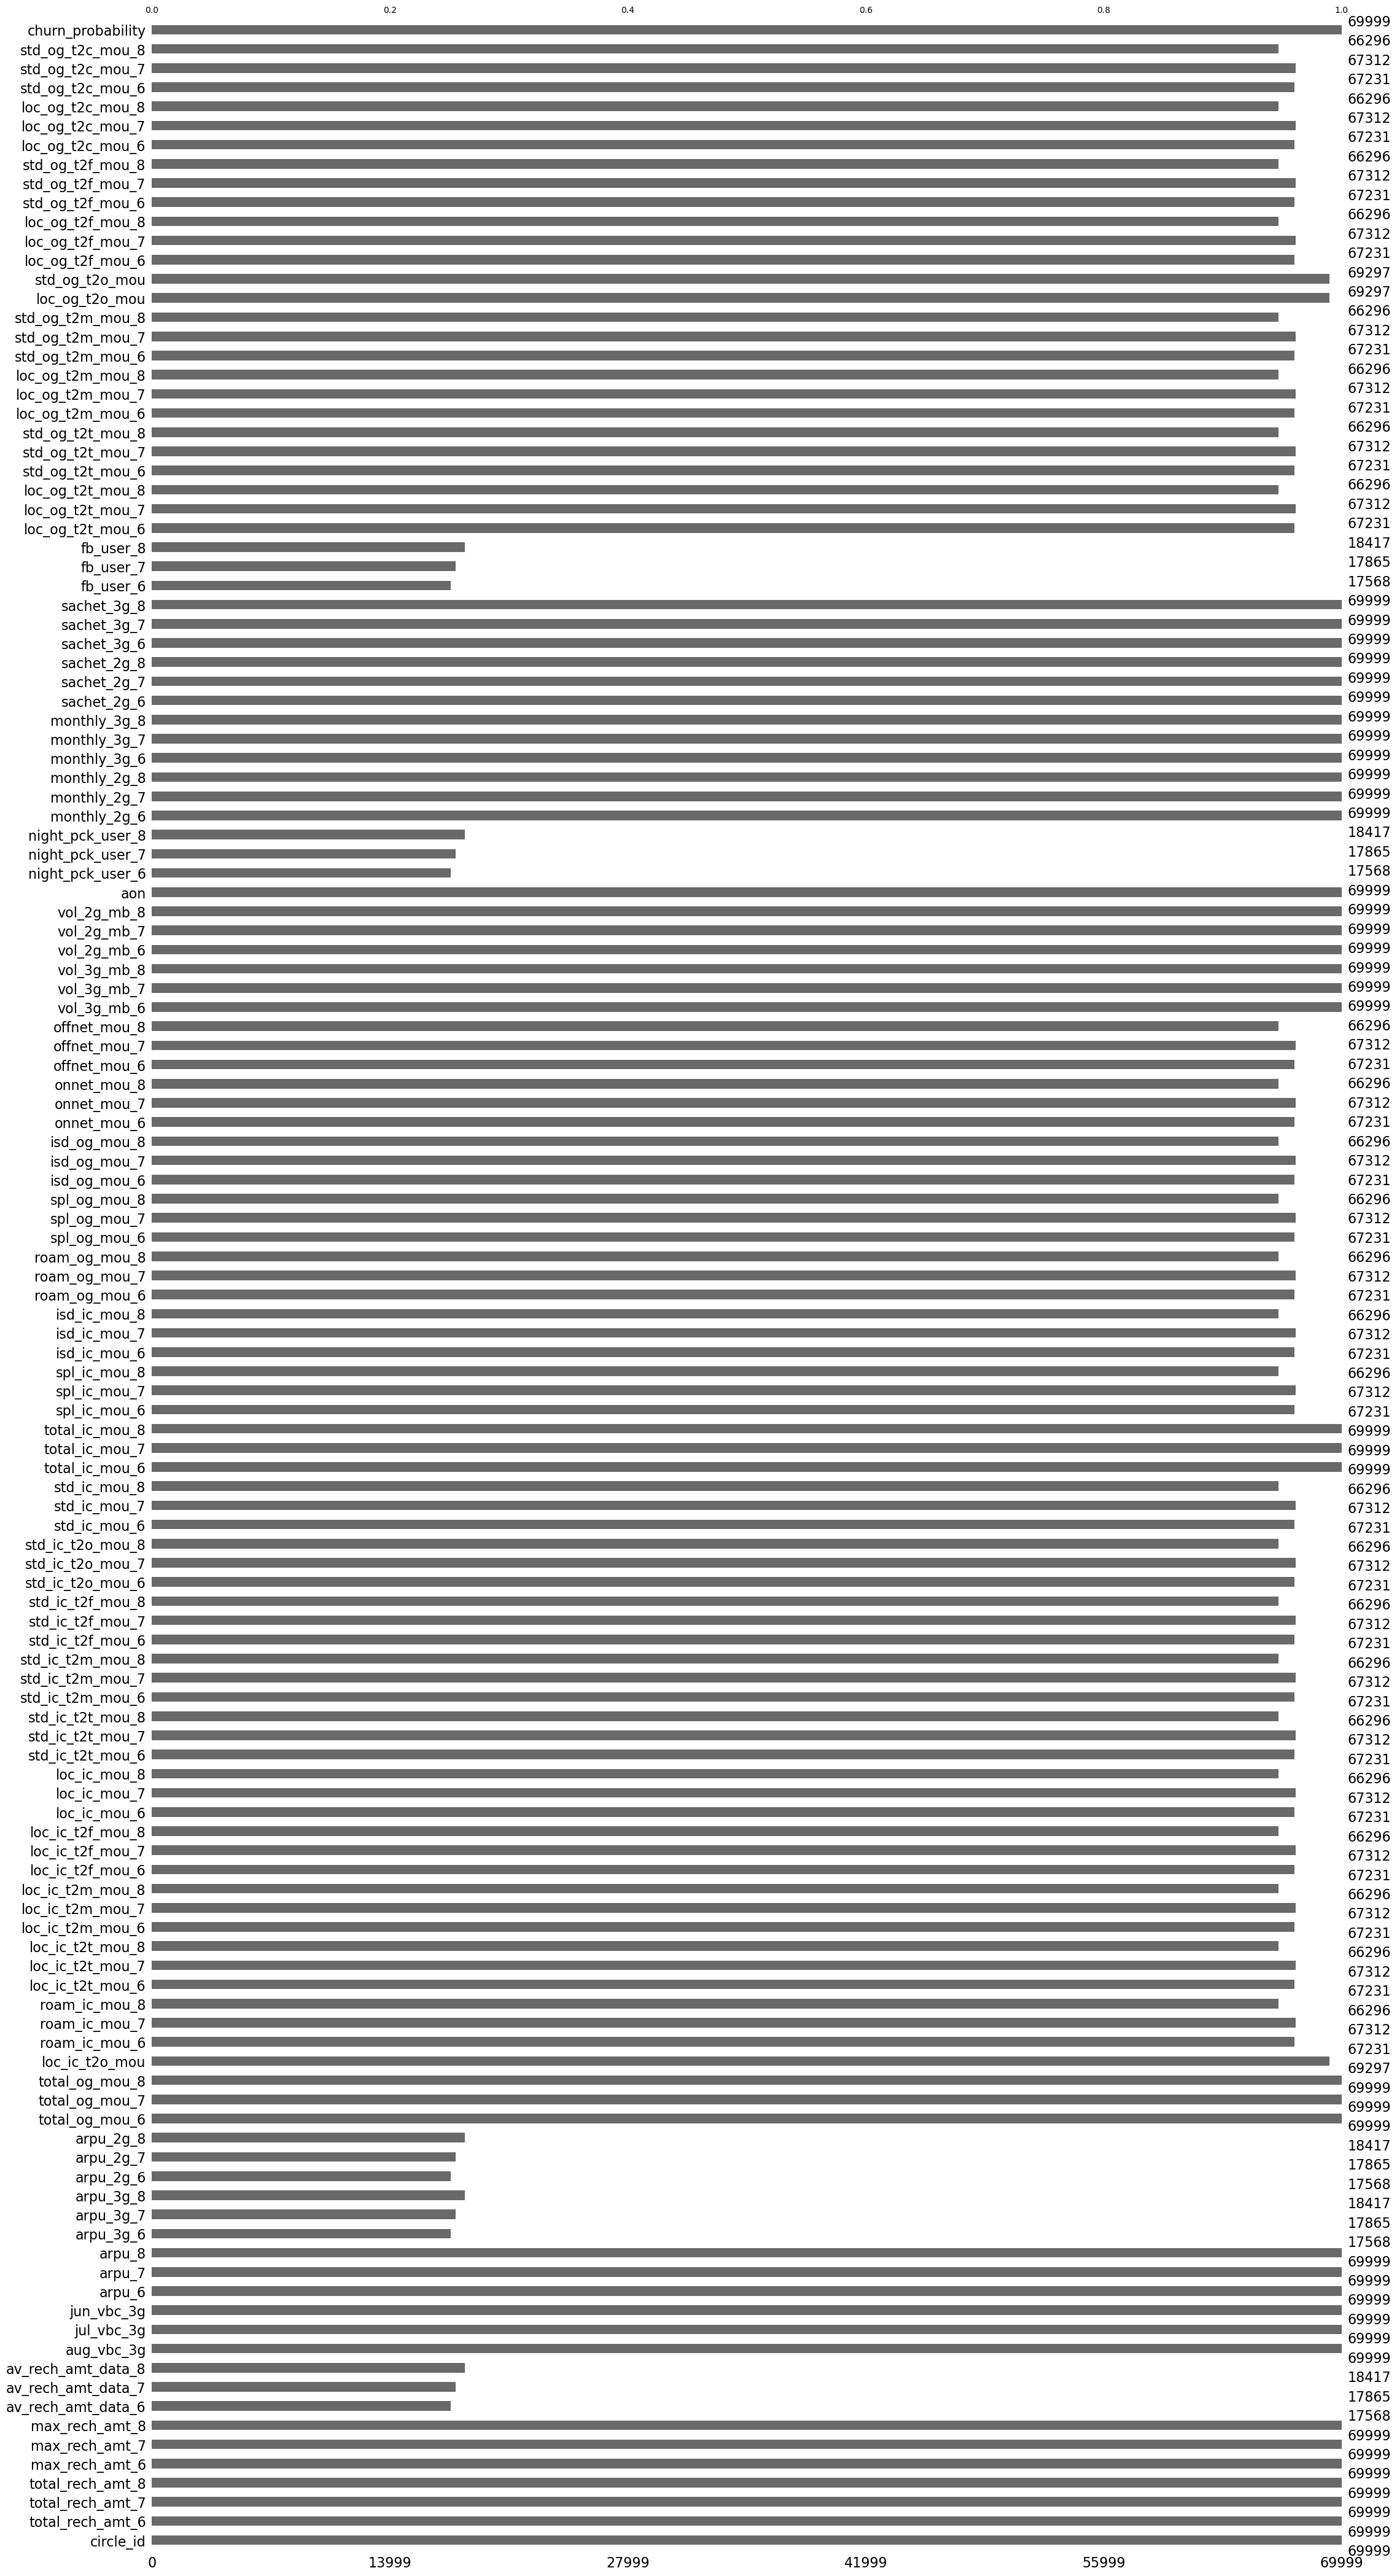

In [15]:
msno.bar(data)

<Axes: >

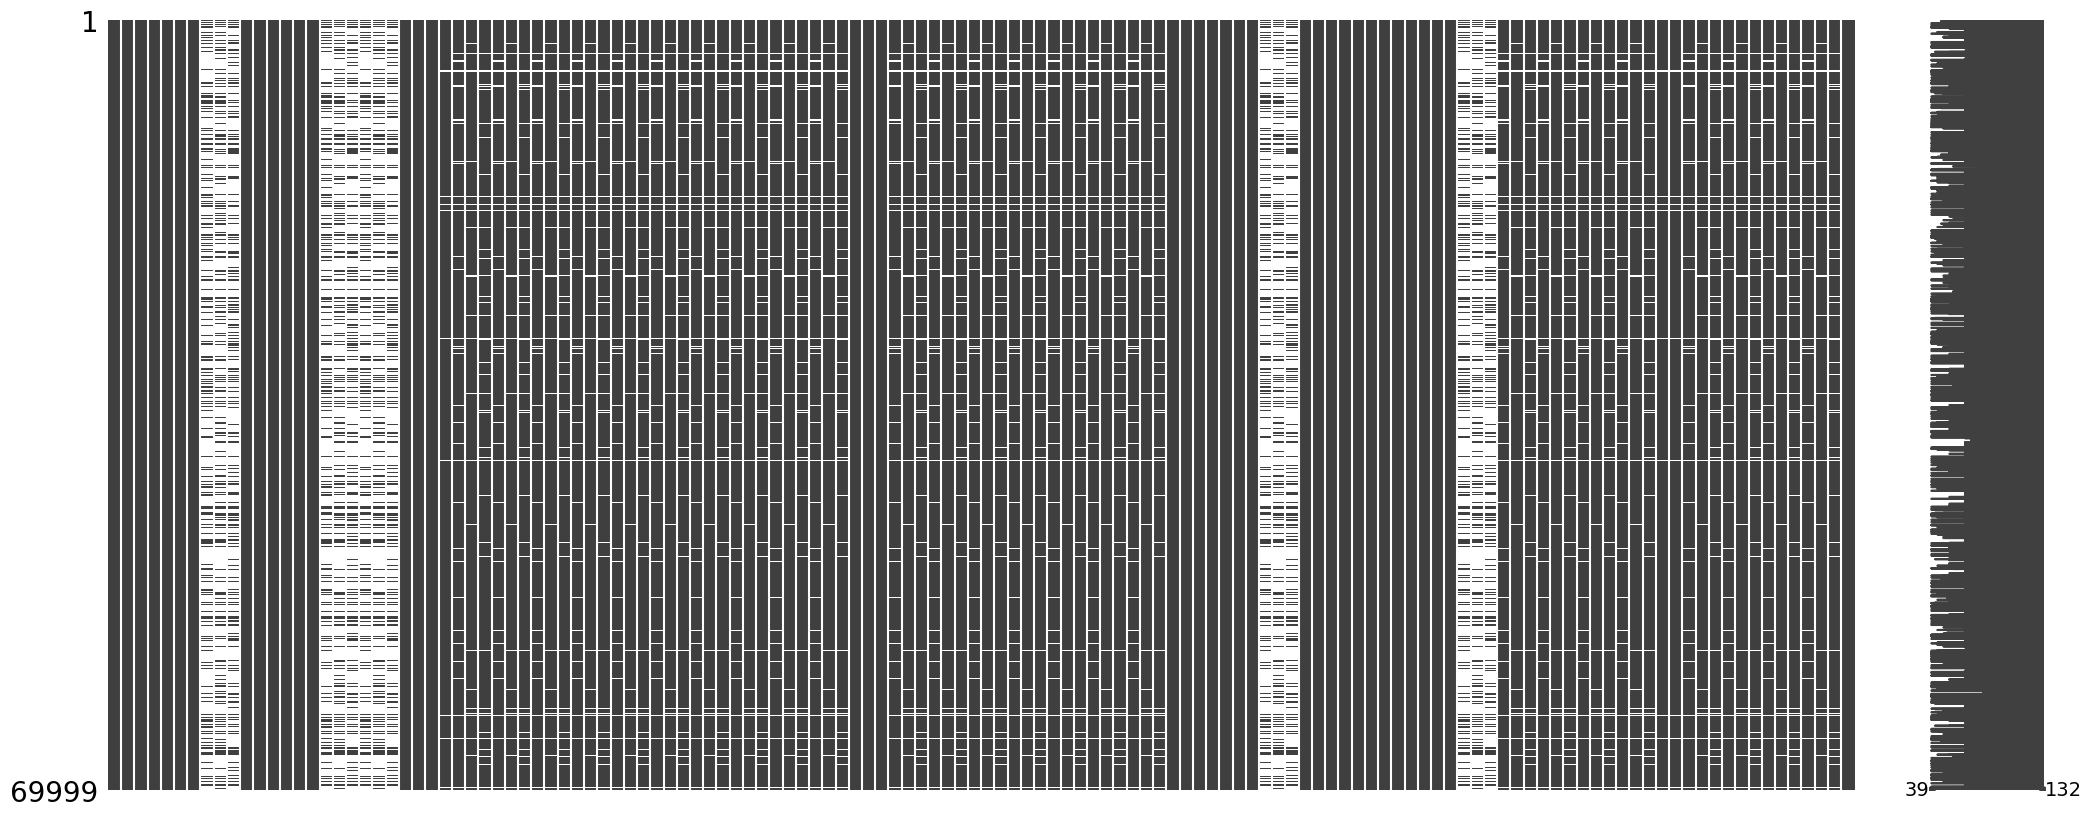

In [16]:
msno.matrix(data)

In [17]:
# Calculating the Missing Percentage values

missing_data_percent = 100*(data.isnull().sum()/len(data))
missing_data_percent

circle_id            0.000000
total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
max_rech_amt_6       0.000000
                       ...   
loc_og_t2c_mou_8     5.290076
std_og_t2c_mou_6     3.954342
std_og_t2c_mou_7     3.838626
std_og_t2c_mou_8     5.290076
churn_probability    0.000000
Length: 132, dtype: float64

In [18]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index # checks for columns with missing data percentages less than or equal to 40% (le stands for "less than or equal").
new_vars

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g',
       ...
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'churn_probability'],
      dtype='object', length=117)

In [19]:
# Drop columns not in `new_vars`
data_f = data[new_vars]

# Check shapes
data_f.shape, data.shape


((69999, 117), (69999, 132))

### ___Imputing the Values those are missing for the new variables___

In [20]:
missing_data_percent_nv = data_f.isnull().any()
impute_cols = missing_data_percent_nv[missing_data_percent_nv.gt(0)].index # The gt(0) function is a shorthand for "greater than 0"
impute_cols

Index(['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_6',
       'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offne

<Axes: >

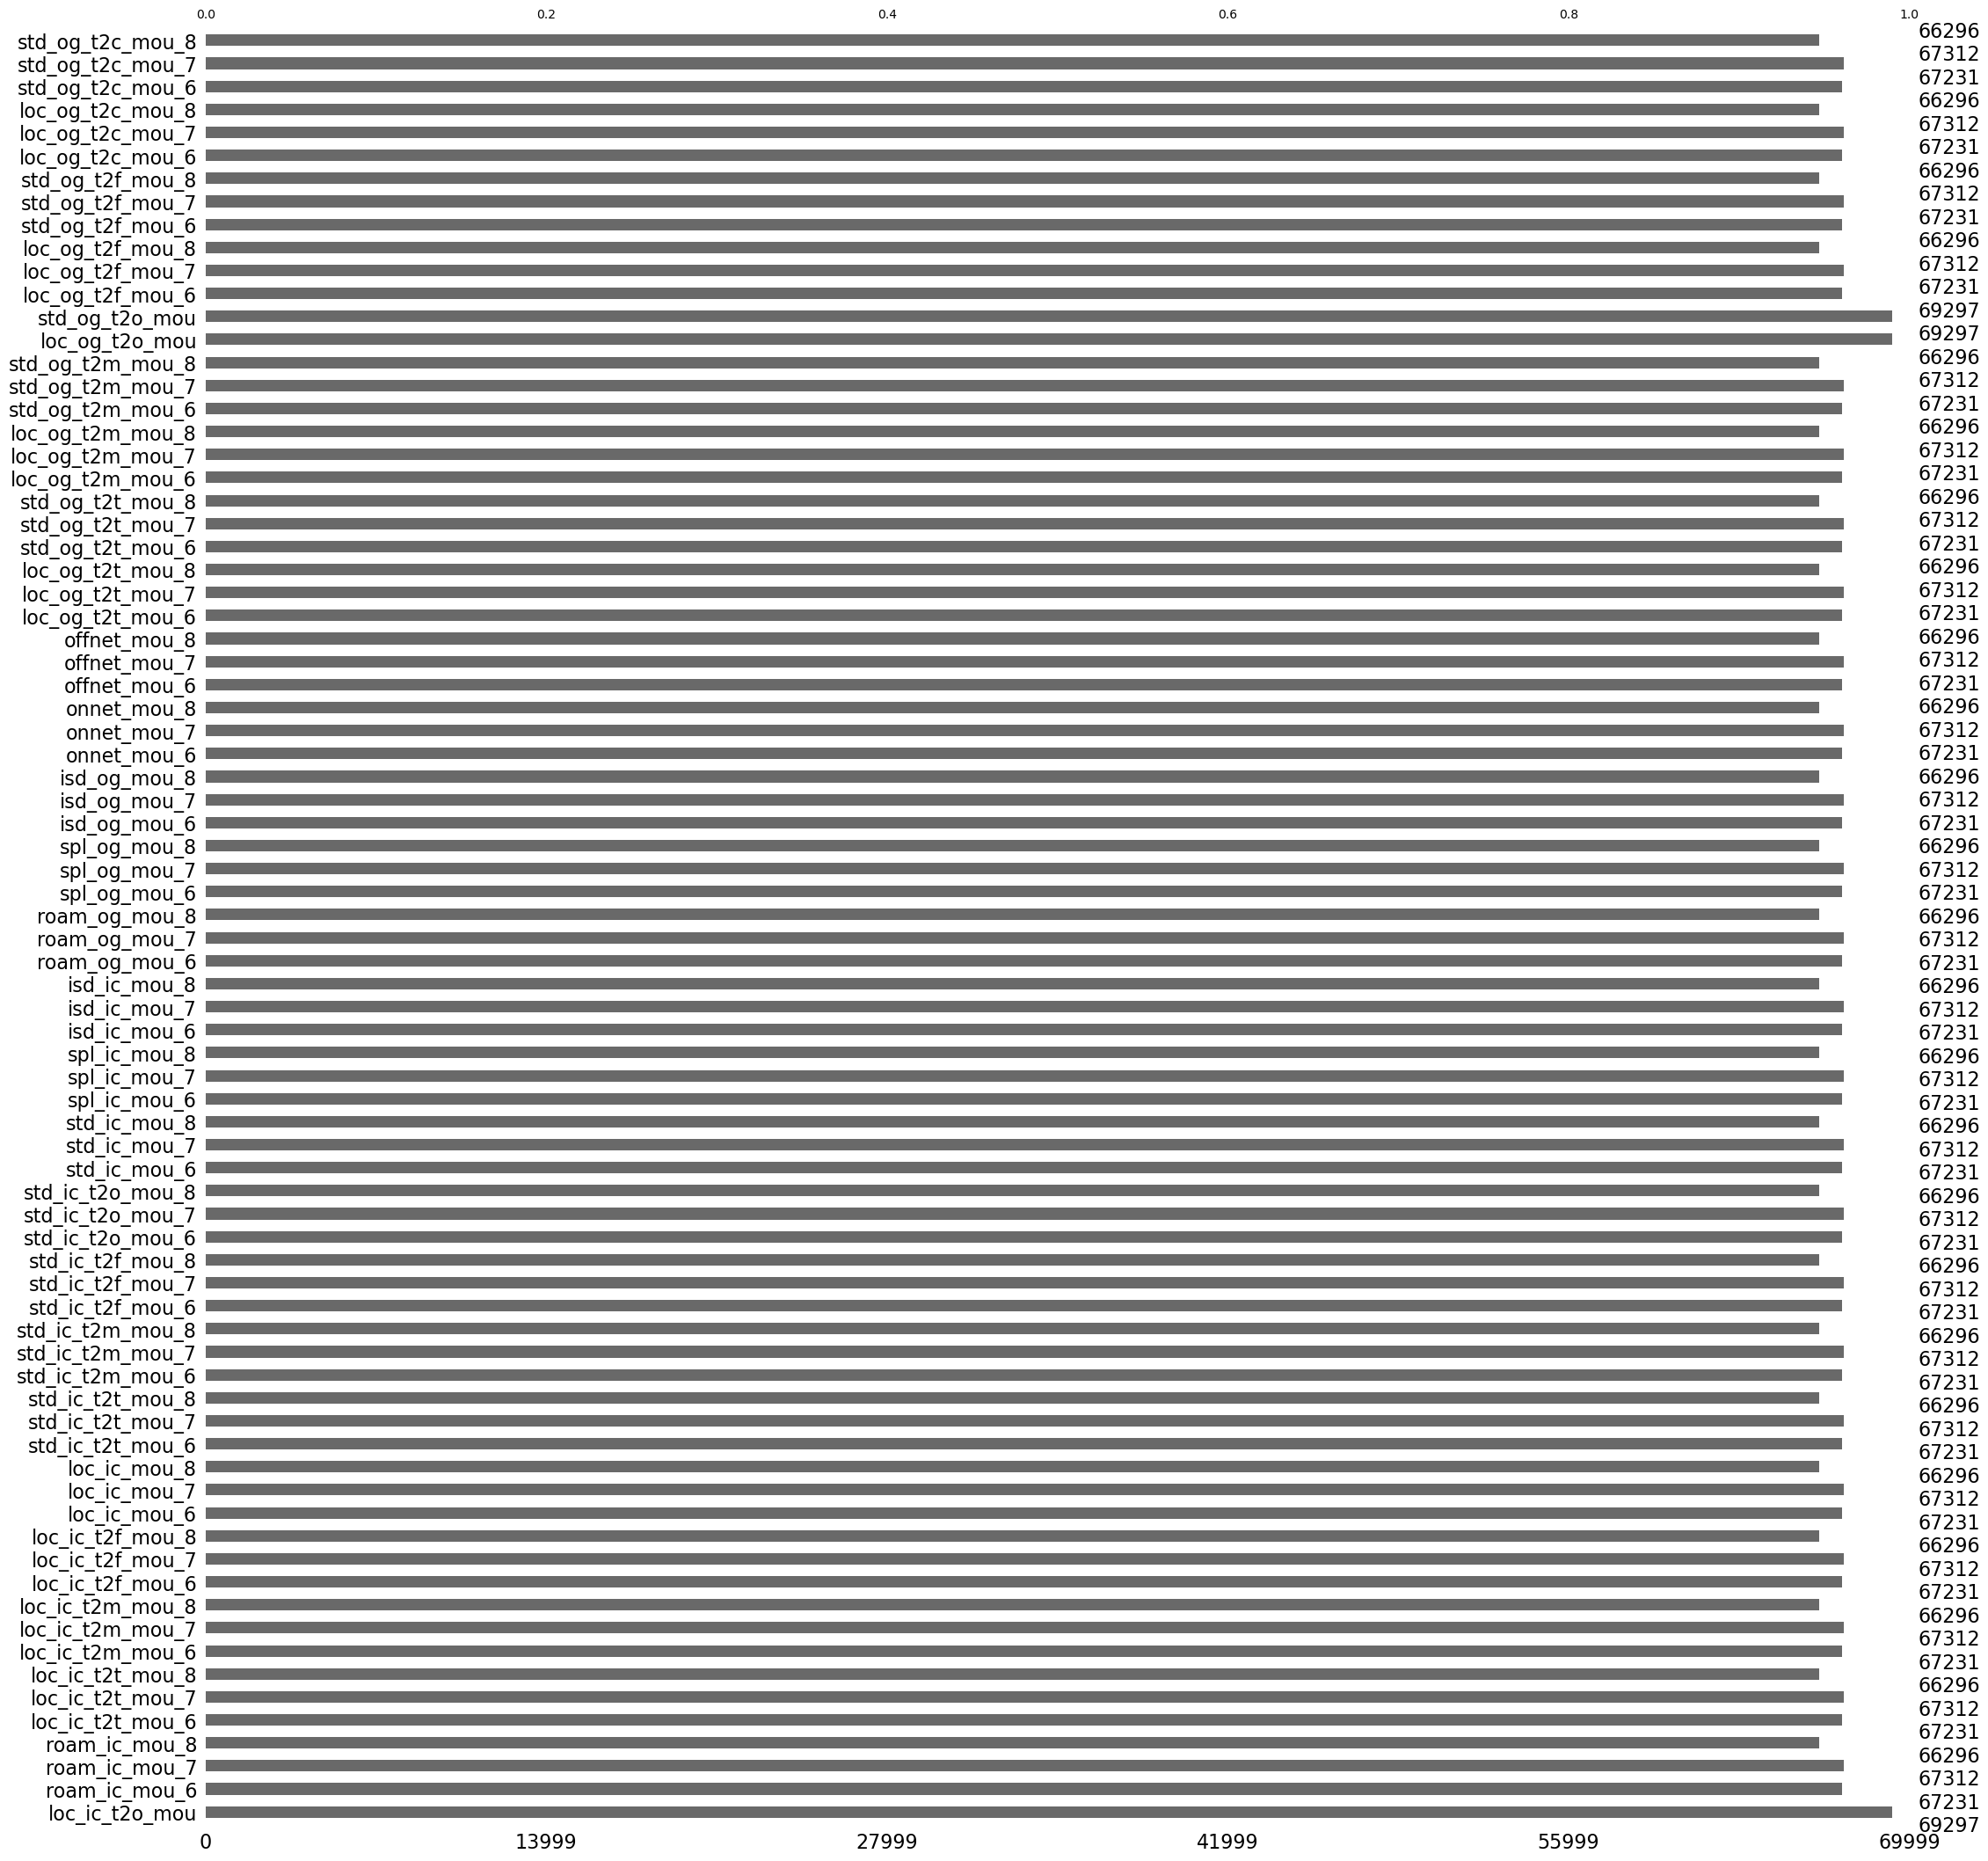

In [21]:
msno.bar(data_f[impute_cols])

In [22]:
mice_imputer = IterativeImputer(max_iter=10, random_state=42, n_nearest_features=5, initial_strategy='median')
data_f[impute_cols] = mice_imputer.fit_transform(data_f[impute_cols])

<Axes: >

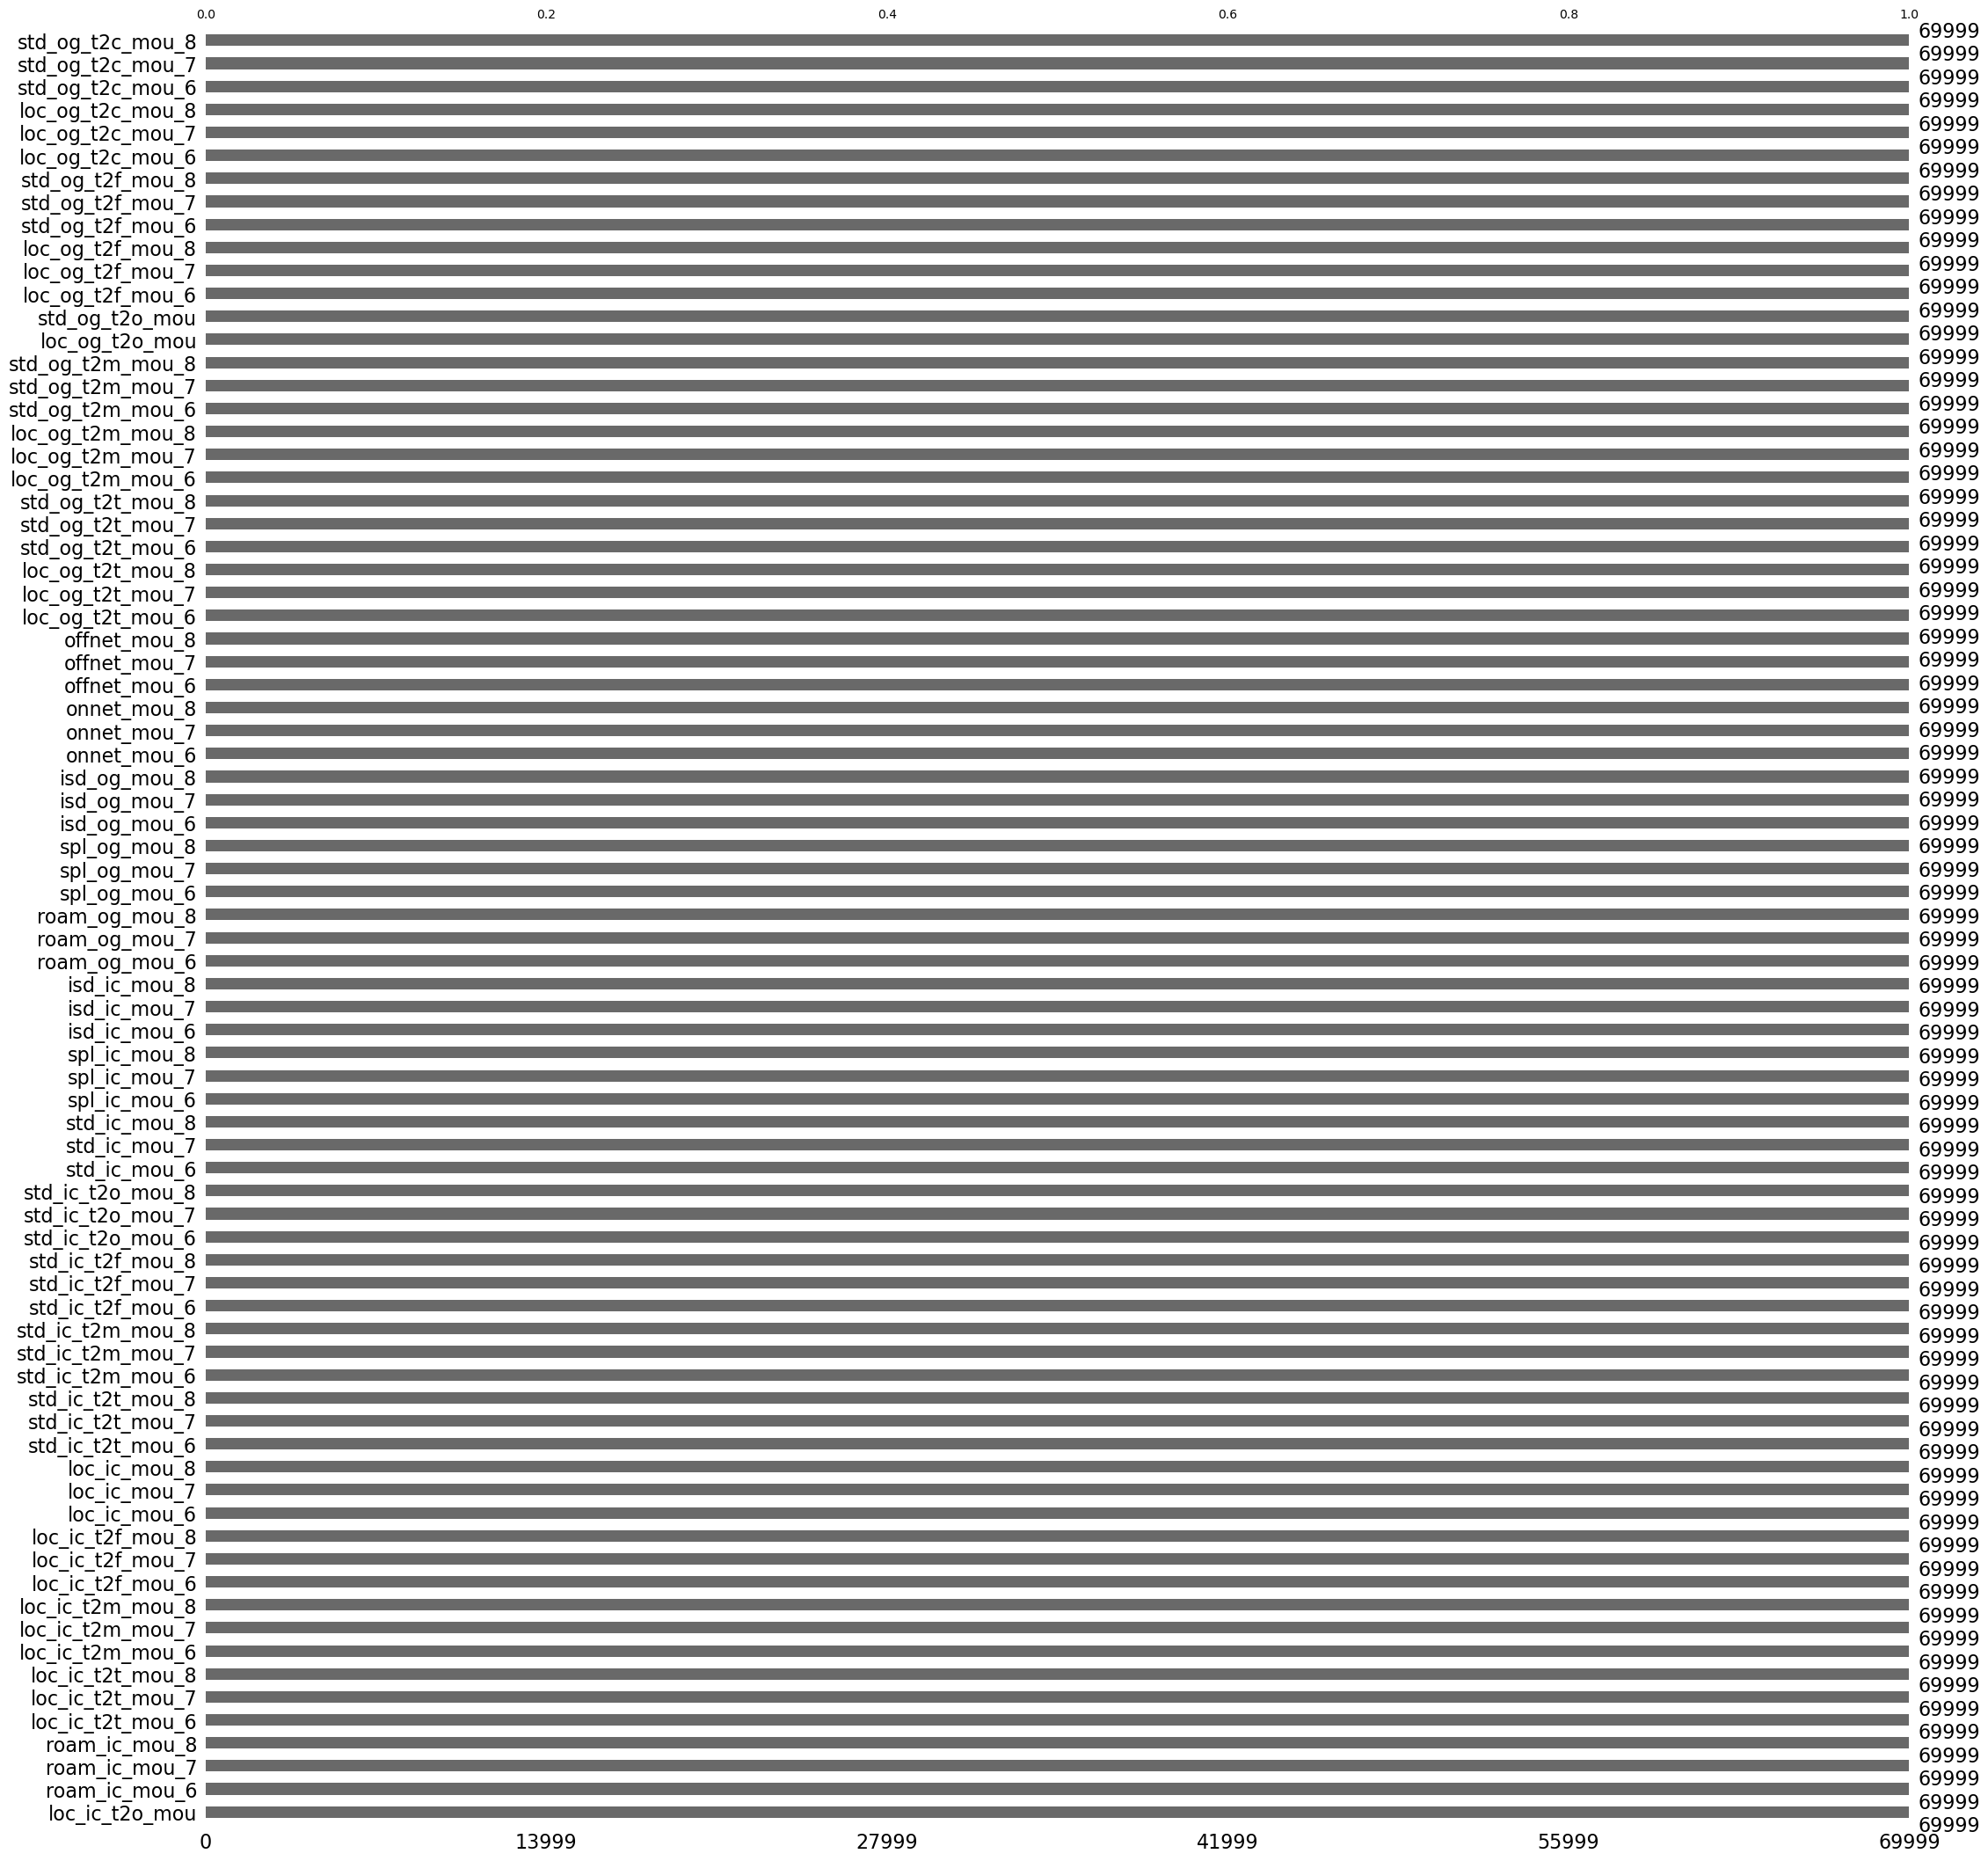

In [23]:
msno.bar(data_f[impute_cols])

In [24]:
data_f.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109                77                65                10   
1         109                 0               145                50   
2         109                70               120                 0   
3         109               160               240               130   
4         109               290               136               122   

    max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  \
id                                                                           
0               65              65              10         0.0         0.0   
1                0             145              50         0.0         0.0   
2               70              70               0         0.0         0.0   
3              110             110              50         0.0         0.0   
4               50              41              30         0.0         0.0   

    jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
id              ...                                                         
0          0.0  ...              0.00               0.0               0.0   
1          0.0  ...              0.00               0.0               0.0   
2          0.0  ...              0.00               0.0               0.0   
3          0.0  ...              0.56               0.0               0.0   
4          0.0  ...              0.00               0.0               0.0   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  \
id                                                                           
0               0.00              0.00              0.00               0.0   
1               0.00             22.01             29.79               0.0   
2               2.14              0.00              0.00               0.0   
3               0.00              0.00              8.03               0.0   
4               0.00              9.85              0.00               0.0   

    std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
id                                                         
0                0.0               0.0                  0  
1                0.0               0.0                  0  
2                0.0               0.0                  0  
3                0.0               0.0                  0  
4                0.0               0.0                  0  

[5 rows x 117 columns]

In [25]:
data_f.describe()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
count    69999.0      69999.000000      69999.000000      69999.000000   
mean       109.0        328.139788        322.376363        323.846355   
std          0.0        404.211068        411.070120        426.181405   
min        109.0          0.000000          0.000000          0.000000   
25%        109.0        110.000000        100.000000         90.000000   
50%        109.0        229.000000        220.000000        225.000000   
75%        109.0        438.000000        430.000000        436.000000   
max        109.0      35190.000000      40335.000000      45320.000000   

       max_rech_amt_6  max_rech_amt_7  max_rech_amt_8    aug_vbc_3g  \
count    69999.000000    69999.000000    69999.000000  69999.000000   
mean       104.569265      104.137573      107.540351     68.108597   
std        121.407701      120.782543      124.396750    269.328659   
min          0.000000        0.000000        0.000000      0.000000   
25%         30.000000       30.000000       30.000000      0.000000   
50%        110.000000      110.000000       98.000000      0.000000   
75%        120.000000      128.000000      144.000000      0.000000   
max       4010.000000     3299.000000     4449.000000  12916.220000   

         jul_vbc_3g   jun_vbc_3g  ...  std_og_t2f_mou_6  std_og_t2f_mou_7  \
count  69999.000000  69999.00000  ...      69999.000000      69999.000000   
mean      65.935830     60.07674  ...          1.121430          1.072492   
std      267.899034    257.22681  ...          7.974359          8.177923   
min        0.000000      0.00000  ...          0.000000         -0.591948   
25%        0.000000      0.00000  ...          0.000000          0.000000   
50%        0.000000      0.00000  ...          0.000000          0.000000   
75%        0.000000      0.00000  ...          0.000000          0.000000   
max     9165.600000  11166.21000  ...        628.560000        465.790000   

       std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean           1.041788          1.128586          1.358420          1.417824   
std            7.514672          5.631844          7.760969          6.386369   
min           -2.443565         -0.665662          0.000000         -1.569337   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.150000   
max          354.160000        342.860000        916.240000        351.830000   

       std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  churn_probability  
count           69999.0           69999.0           69999.0       69999.000000  
mean                0.0               0.0               0.0           0.101887  
std                 0.0               0.0               0.0           0.302502  
min                 0.0               0.0               0.0           0.000000  
25%                 0.0               0.0               0.0           0.000000  
50%                 0.0               0.0               0.0           0.000000  
75%                 0.0               0.0               0.0           0.000000  
max                 0.0               0.0               0.0           1.000000  

[8 rows x 117 columns]

In [26]:
data_f.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 117 columns):
 #    Column             Dtype  
---   ------             -----  
 0    circle_id          int64  
 1    total_rech_amt_6   int64  
 2    total_rech_amt_7   int64  
 3    total_rech_amt_8   int64  
 4    max_rech_amt_6     int64  
 5    max_rech_amt_7     int64  
 6    max_rech_amt_8     int64  
 7    aug_vbc_3g         float64
 8    jul_vbc_3g         float64
 9    jun_vbc_3g         float64
 10   arpu_6             float64
 11   arpu_7             float64
 12   arpu_8             float64
 13   total_og_mou_6     float64
 14   total_og_mou_7     float64
 15   total_og_mou_8     float64
 16   loc_ic_t2o_mou     float64
 17   roam_ic_mou_6      float64
 18   roam_ic_mou_7      float64
 19   roam_ic_mou_8      float64
 20   loc_ic_t2t_mou_6   float64
 21   loc_ic_t2t_mou_7   float64
 22   loc_ic_t2t_mou_8   float64
 23   loc_ic_t2m_mou_6   float64
 24   loc_ic_t2m_mou_7   float64
 25 

# ___Exploratory Data Analysis (EDA)___

### ___Overview___

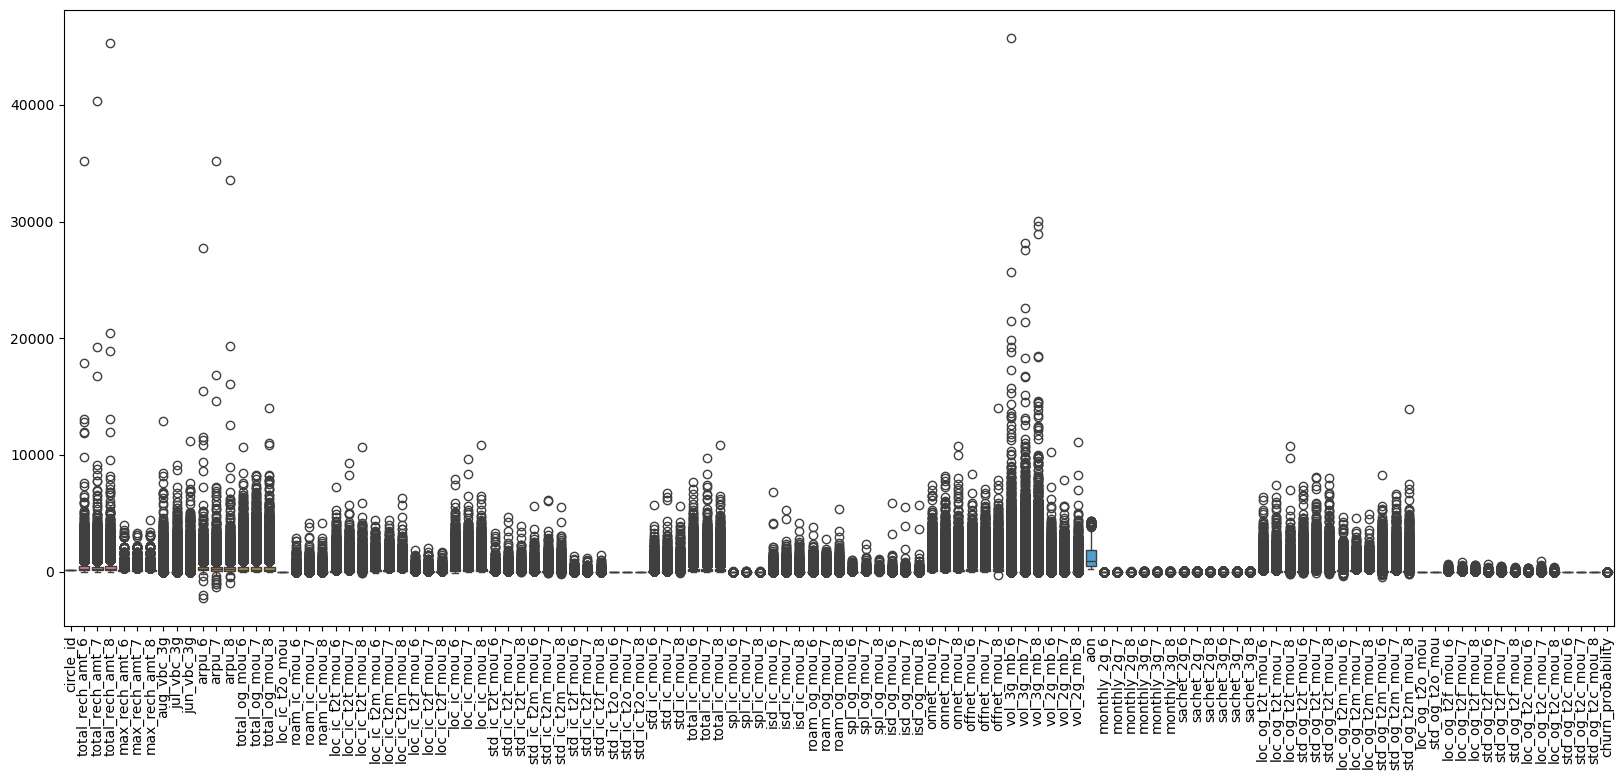

In [27]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data = data_f)
plt.show()

### ___Filter high-value customers___
to get a clearer view using EDA

In [28]:
id_cols=[x for x in test_df.columns if 'id' in x]
amt_cols=[x for x in test_df.columns if 'amt' in x]
mou_cols=[x for x in test_df.columns if 'mou' in x]
date_cols=[x for x in test_df.columns if 'date' in x]
arpu_cols=['arpu_6','arpu_7','arpu_8']
aon_cols=['aon']
target_col=['churn_probability']
other_col=[x for x in list(test_df.columns) if x not in id_cols + amt_cols + mou_cols + date_cols + arpu_cols + aon_cols + target_col] 

In [29]:
id_cols=[x for x in unseen_df.columns if 'id' in x]
amt_cols=[x for x in unseen_df.columns if 'amt' in x]
mou_cols=[x for x in unseen_df.columns if 'mou' in x]
date_cols=[x for x in unseen_df.columns if 'date' in x]
arpu_cols=['arpu_6','arpu_7','arpu_8']
aon_cols=['aon']
target_col=['churn_probability']
other_col=[x for x in list(unseen_df.columns) if x not in id_cols + amt_cols + mou_cols + date_cols + arpu_cols + aon_cols + target_col] 

In [30]:
test_df[arpu_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   arpu_6  69999 non-null  float64
 1   arpu_7  69999 non-null  float64
 2   arpu_8  69999 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [ ]:
test_df[arpu_cols].describe()

arpu_6        arpu_7        arpu_8
count  69999.000000  69999.000000  69999.000000
mean     283.134365    278.185912    278.858826
std      334.213918    344.366927    351.924315
min    -2258.709000  -1289.715000   -945.808000
25%       93.581000     86.714000     84.095000
50%      197.484000    191.588000    192.234000
75%      370.791000    365.369500    369.909000
max    27731.088000  35145.834000  33543.624000

In [32]:
test_df['avg_arpu']=(test_df['arpu_6']+test_df['arpu_6']+test_df['arpu_6'])/3

In [33]:
test_df.avg_arpu.quantile(0.7)

323.9982

In [34]:
high_val_cust = test_df.loc[test_df.avg_arpu > test_df.avg_arpu.quantile(0.7), :]
high_val_cust = high_val_cust.reset_index(drop=True)
high_val_cust.shape

(21000, 173)

In [35]:
high_val_cust['tc_mou_8'] = high_val_cust.total_ic_mou_8 + high_val_cust.total_og_mou_8

In [36]:
high_val_cust['total_internet_mb_8'] =  high_val_cust.vol_2g_mb_8 + high_val_cust.vol_3g_mb_8

In [37]:
high_val_cust['churn'] = high_val_cust.apply(lambda row: 1 if (row.tc_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)

In [ ]:
high_val_cust[['churn','total_ic_mou_8','total_og_mou_8','vol_2g_mb_8','vol_3g_mb_8']]

churn  total_ic_mou_8  total_og_mou_8  vol_2g_mb_8  vol_3g_mb_8
0          0           17.31            3.14         0.00          0.0
1          0           26.99          687.41         0.00          0.0
2          0          369.53          227.41         0.00          0.0
3          0          629.94          391.53       354.35          0.0
4          0          203.29          387.81         0.00          0.0
...      ...             ...             ...          ...          ...
20995      0           98.06          474.51         0.00          0.0
20996      0          366.89          242.69         0.00          0.0
20997      0          551.36         1099.61         0.00          0.0
20998      0          318.86          915.38         0.00          0.0
20999      0          414.54          342.29         0.00          0.0

[21000 rows x 5 columns]

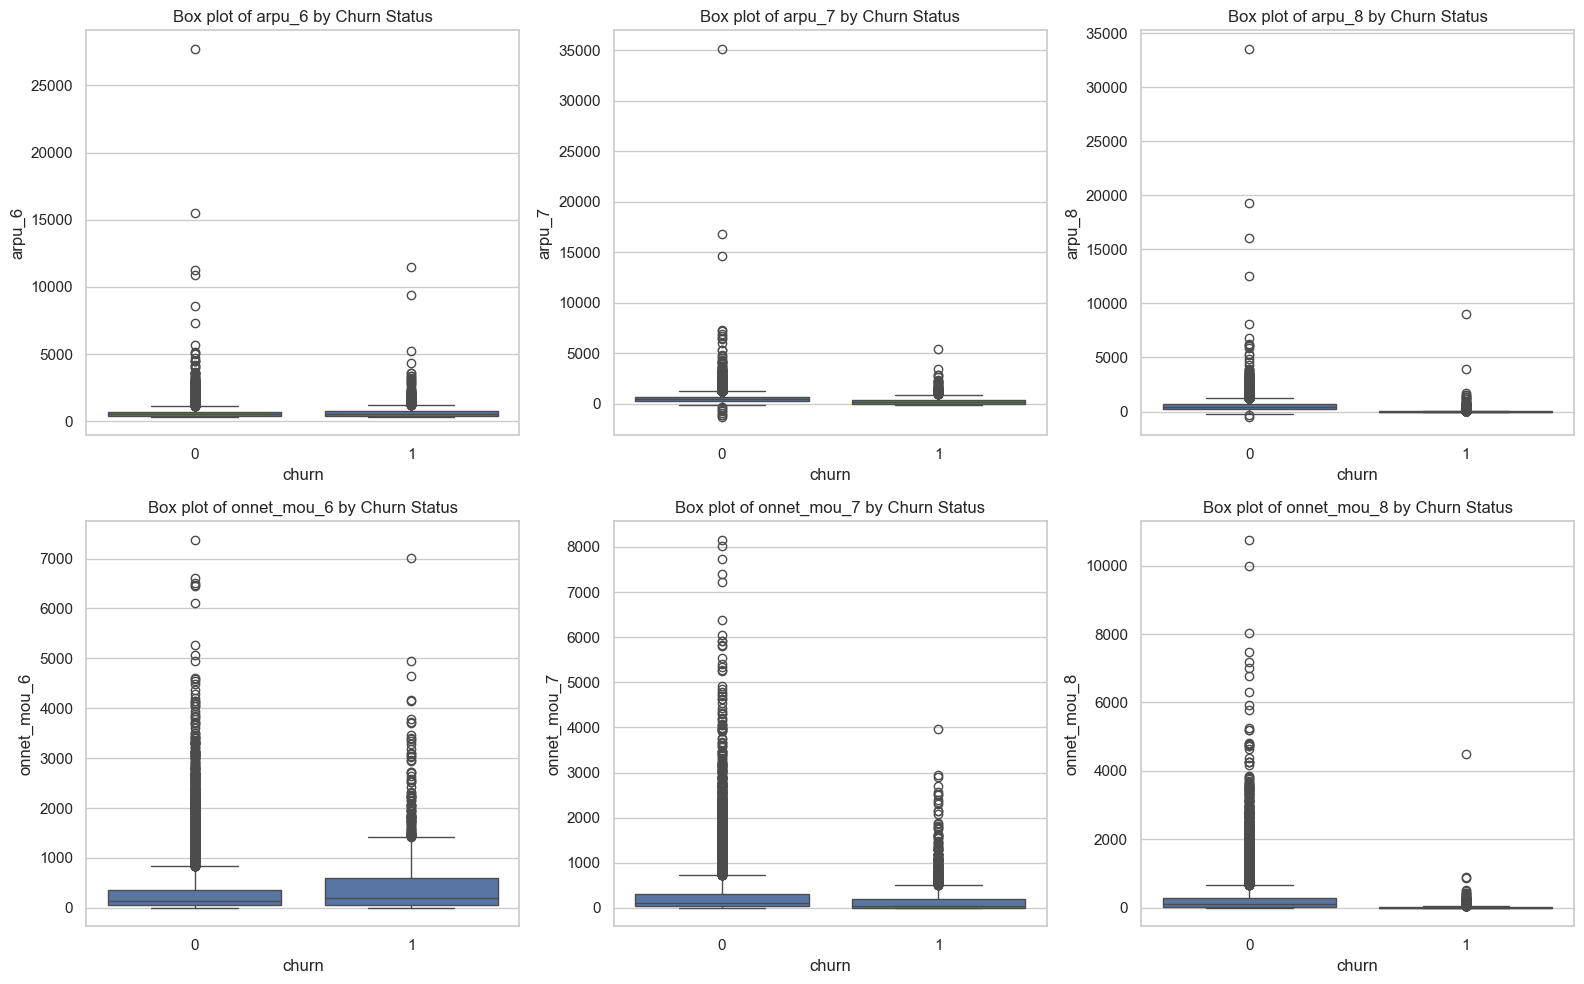

In [39]:
sns.set(style="whitegrid")


features_to_plot = ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'churn']

# Box plots to visualize the distribution of these features, separated by churn status
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_to_plot[:-1]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='churn', y=feature, data=high_val_cust)
    plt.title(f'Box plot of {feature} by Churn Status')

plt.tight_layout()
plt.show()

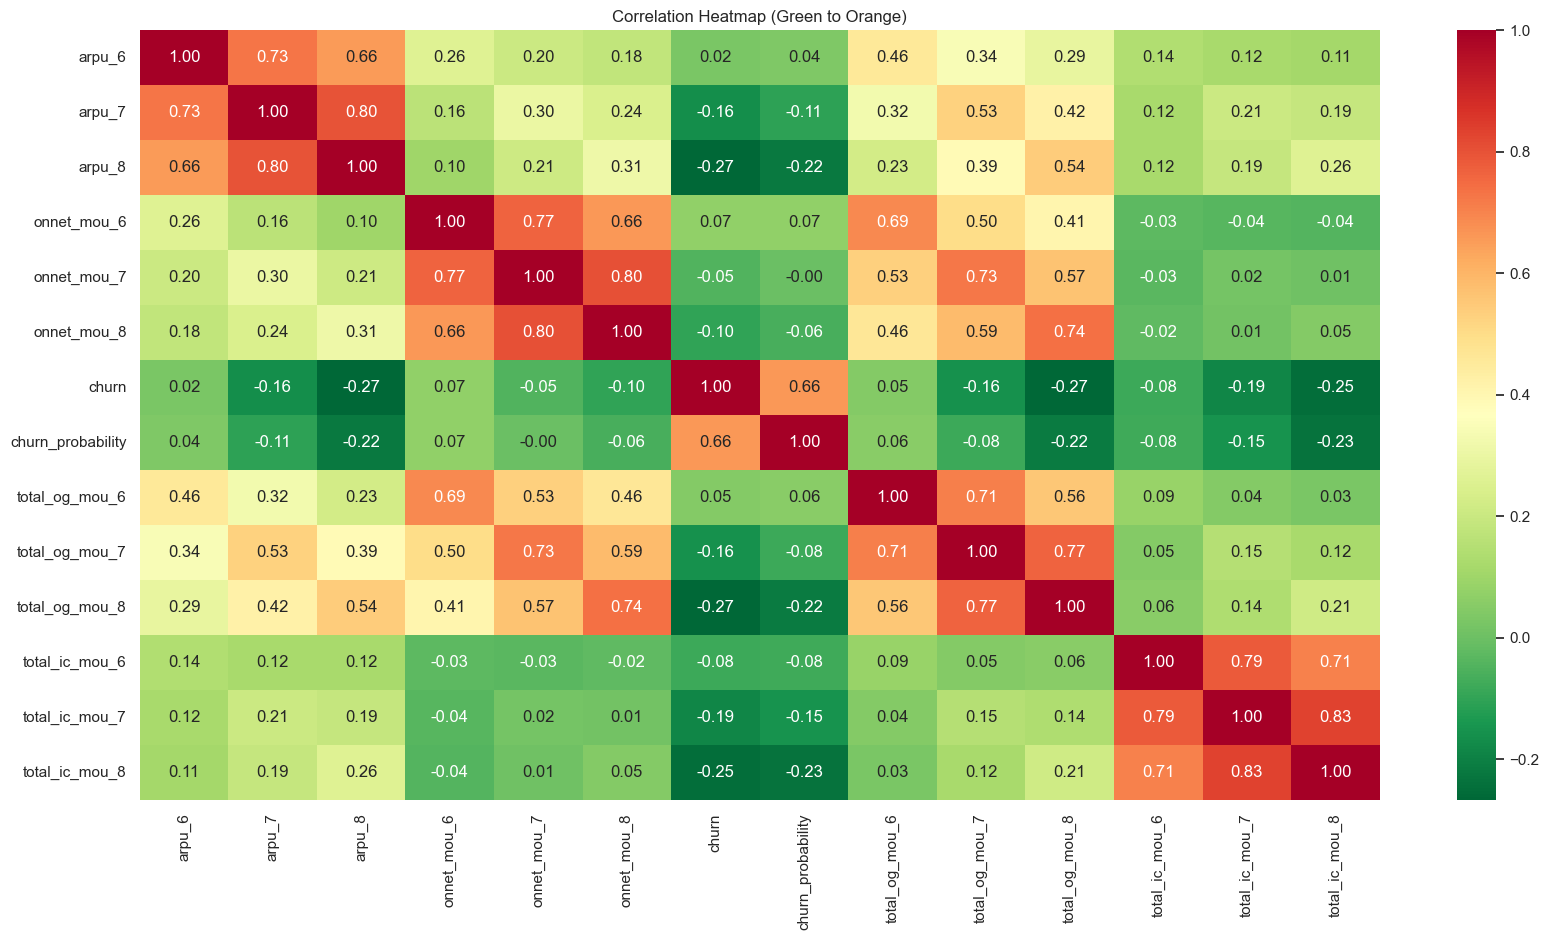

In [40]:
plt.figure(figsize=(20, 10))
mou_total = [col for col in high_val_cust.columns if 'mou' in col.lower() and 'total' in col.lower()]
correlation_matrix = high_val_cust[['arpu_6', 'arpu_7', 'arpu_8','onnet_mou_6', 
                                    'onnet_mou_7', 'onnet_mou_8','churn',
                                    'churn_probability']+mou_total].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn_r', cbar=True)
plt.title('Correlation Heatmap (Green to Orange)')
plt.show()

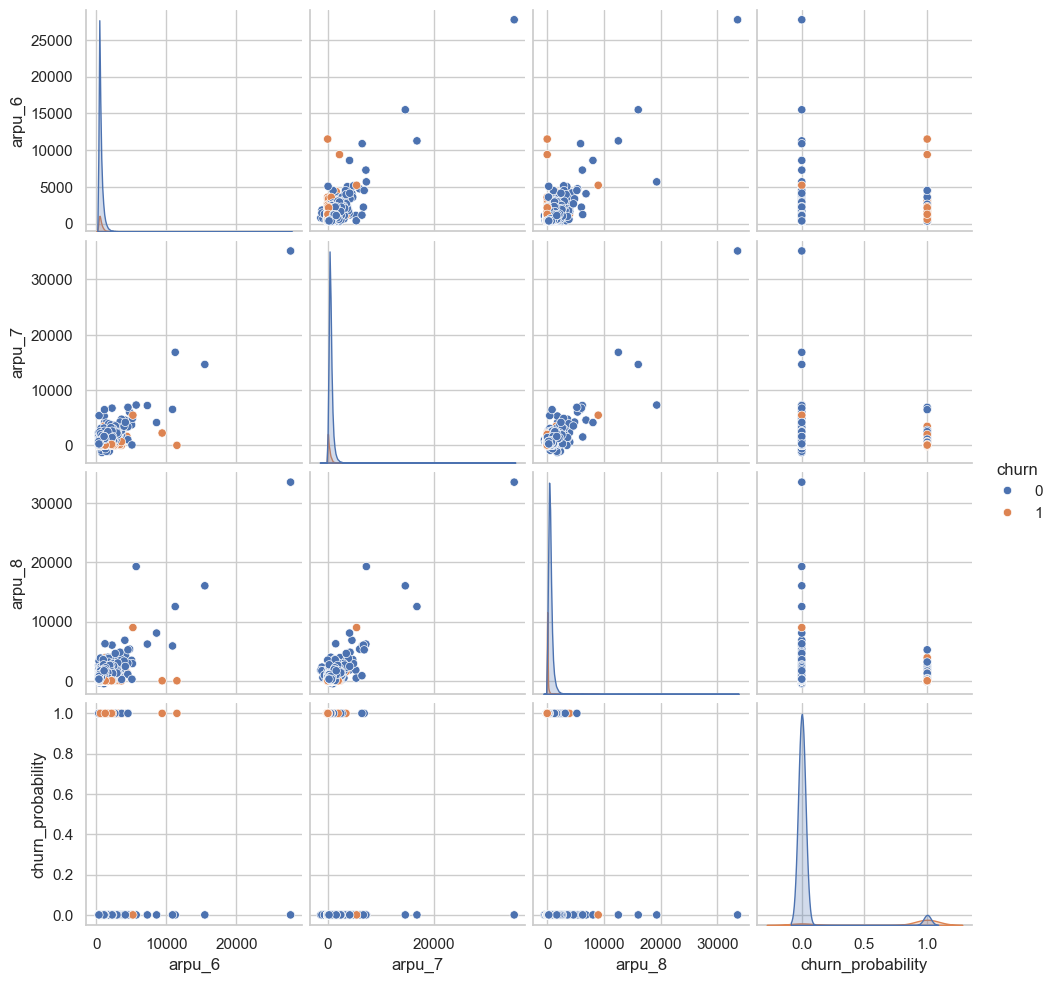

In [41]:
selected_for_pairplot = [
    'arpu_6', 'arpu_7', 'arpu_8', 
     'churn', 'churn_probability'
]

sns.pairplot(high_val_cust[selected_for_pairplot], hue='churn')
plt.show()

In [42]:
amount_data = test_df.loc[:, test_df.columns.str.contains('amt')]

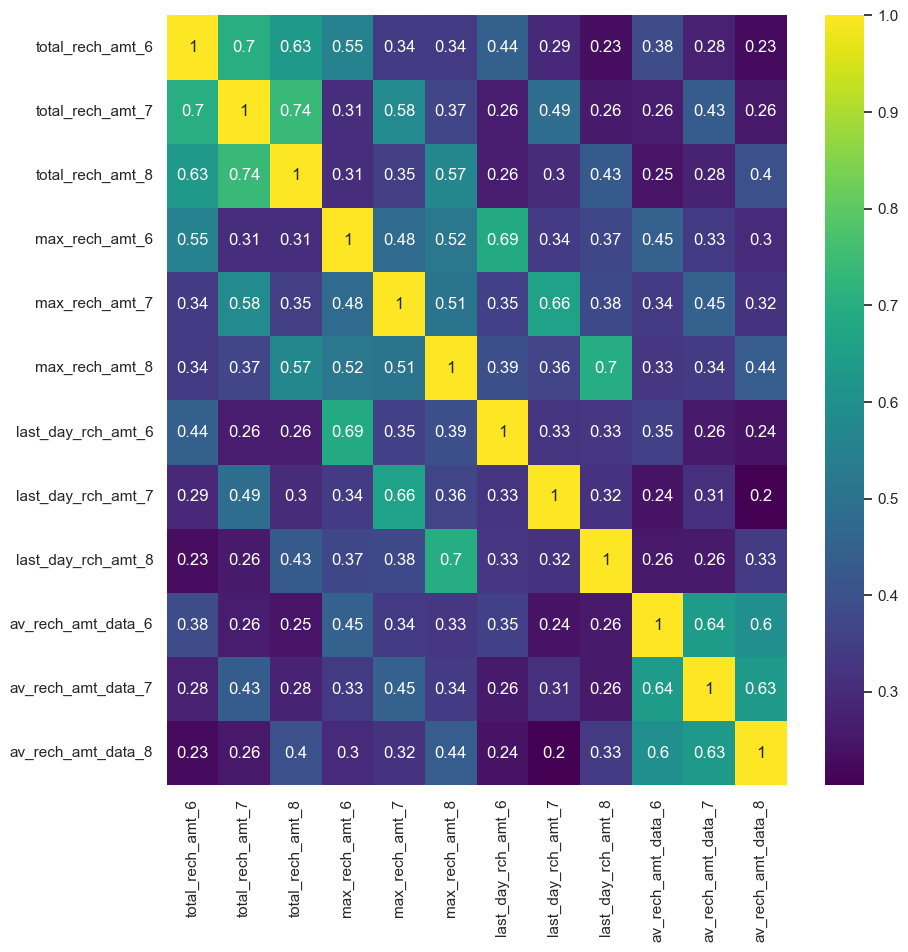

In [43]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

In [44]:
data2g = test_df.loc[:, test_df.columns.str.contains('2g')]
data3g = test_df.loc[:, test_df.columns.str.contains('3g')]

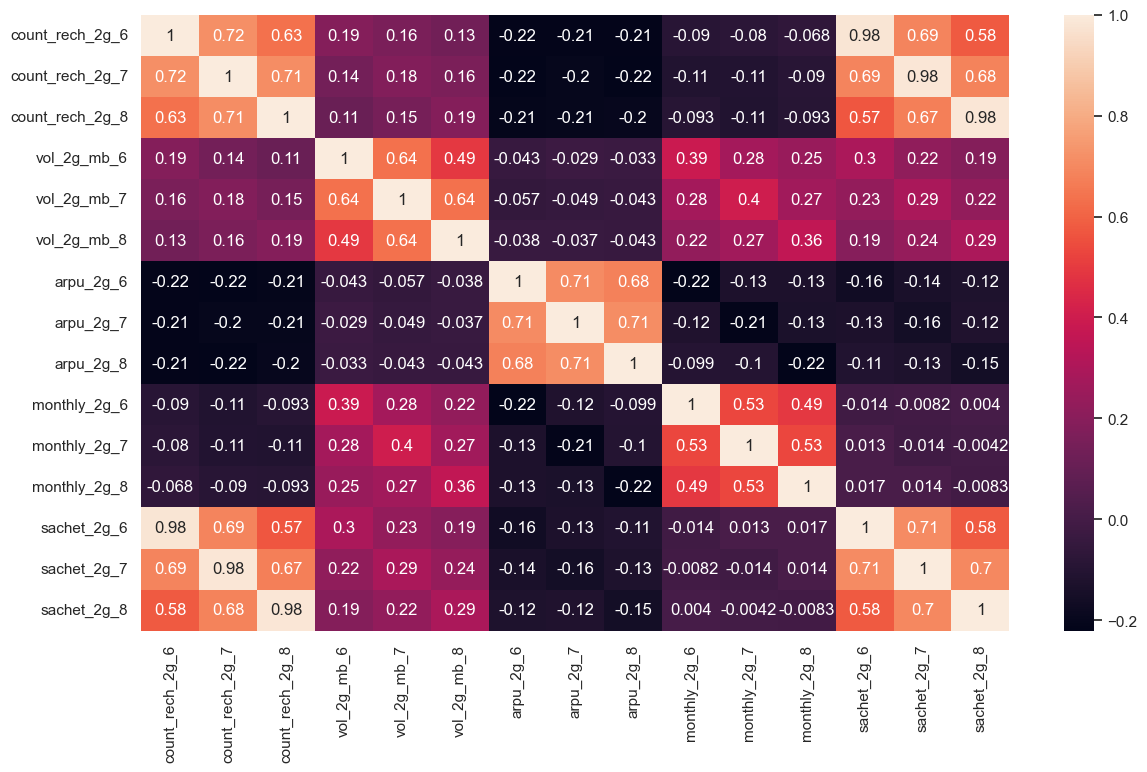

In [45]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

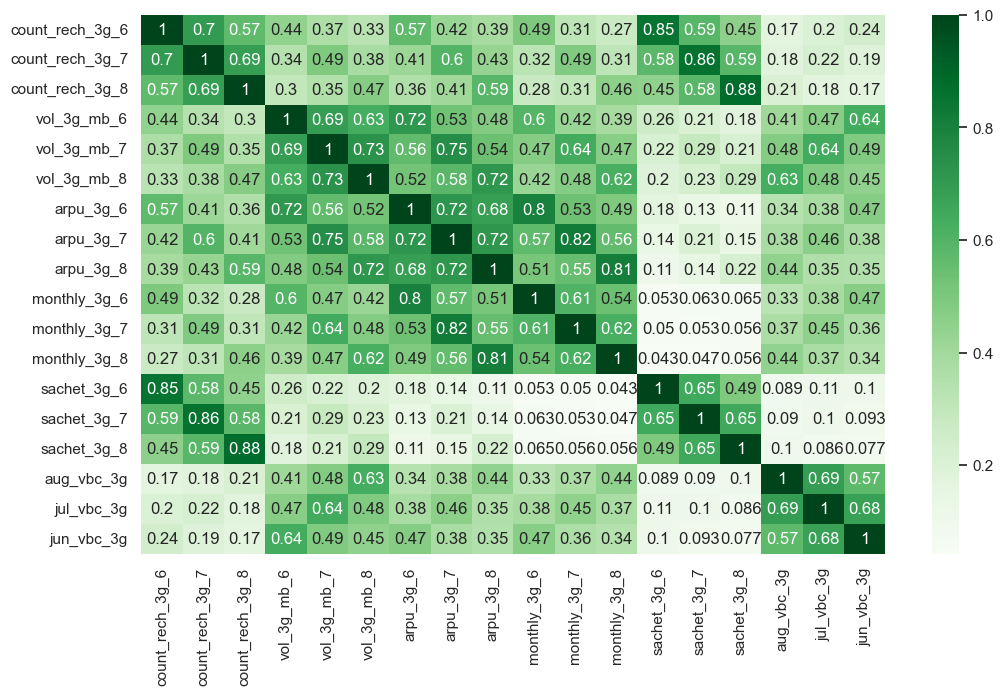

In [46]:
#data3g
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

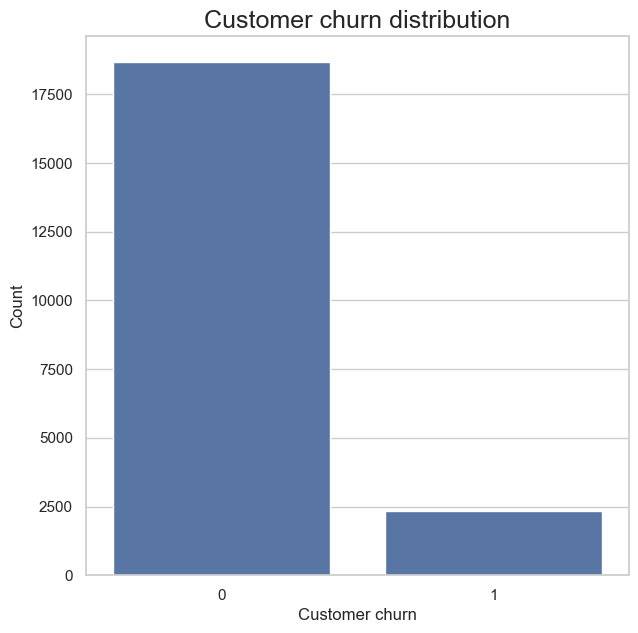

In [47]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_cust['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

# ___Feature Engineering___

#### ___Creating X and Y dataset___

In [48]:
X = data_f.drop(['circle_id'],axis = 1).iloc[:,:-1]
y = data_f.iloc[:,-1]

### ___Handeling Outliers___
Features show there a lot of outliers. These can be capped with k-sigma method.

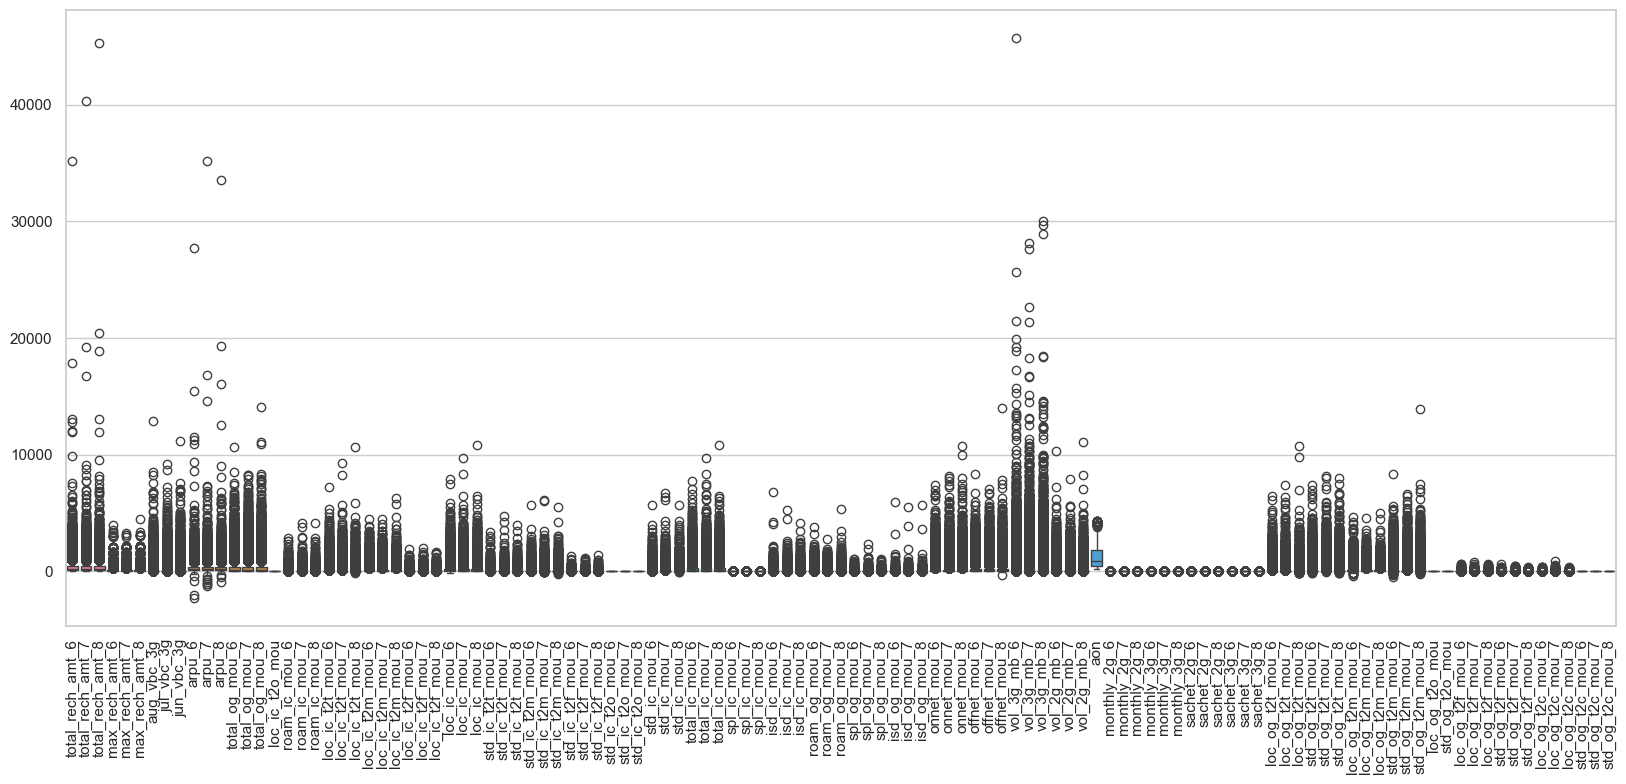

In [49]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data = X)
plt.show()

In [50]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [51]:
data_f2 = X.apply(cap_outliers, axis=0)
data_f2.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
id                                                                         
0               77.0              65.0              10.0            65.0   
1                0.0             145.0              50.0             0.0   
2               70.0             120.0               0.0            70.0   
3              160.0             240.0             130.0           110.0   
4              290.0             136.0             122.0            50.0   

    max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
id                                                                       
0             65.0            10.0         0.0         0.0         0.0   
1            145.0            50.0         0.0         0.0         0.0   
2             70.0             0.0         0.0         0.0         0.0   
3            110.0            50.0         0.0         0.0         0.0   
4             41.0            30.0         0.0         0.0         0.0   

     arpu_6  ...  loc_og_t2f_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
id           ...                                                         
0    31.277  ...              0.00              0.00               0.0   
1     0.000  ...              0.00              0.00               0.0   
2    60.806  ...              0.00              0.00               0.0   
3   156.362  ...              0.00              0.56               0.0   
4   240.708  ...              5.01              0.00               0.0   

    std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                           
0                0.0              0.00              0.00          0.000000   
1                0.0              0.00             22.01         20.576932   
2                0.0              2.14              0.00          0.000000   
3                0.0              0.00              0.00          8.030000   
4                0.0              0.00              9.85          0.000000   

    std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  
id                                                        
0                0.0               0.0               0.0  
1                0.0               0.0               0.0  
2                0.0               0.0               0.0  
3                0.0               0.0               0.0  
4                0.0               0.0               0.0  

[5 rows x 115 columns]

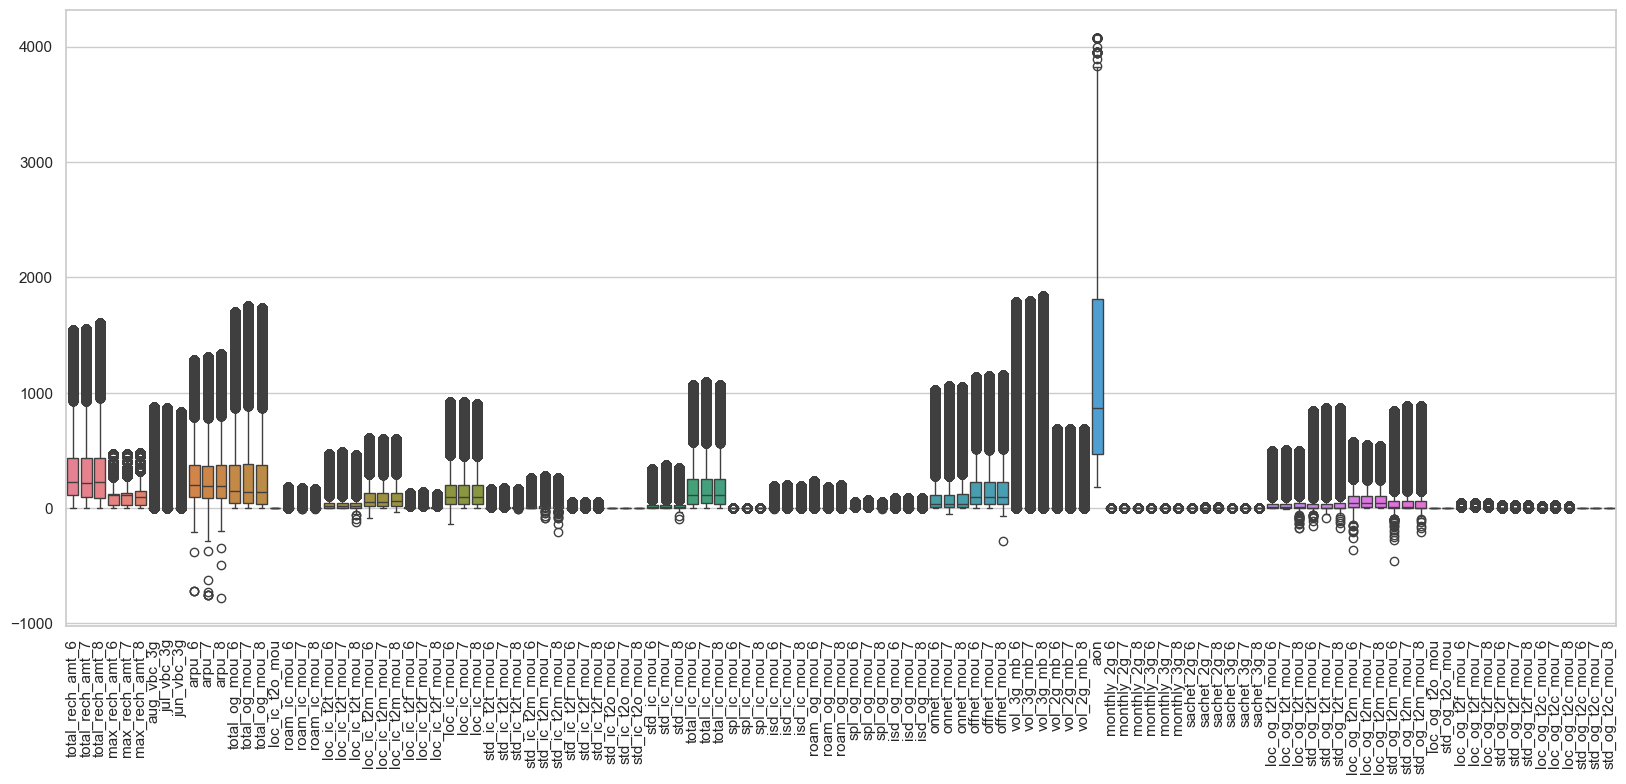

In [52]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.boxplot(data=data_f2)
plt.show()

### ___DataFrame Scaling___

In [53]:
scaler = MinMaxScaler()
df_fs = scaler.fit_transform(data_f2)
data_f2_s = pd.DataFrame(df_fs, columns=data_f2.columns)

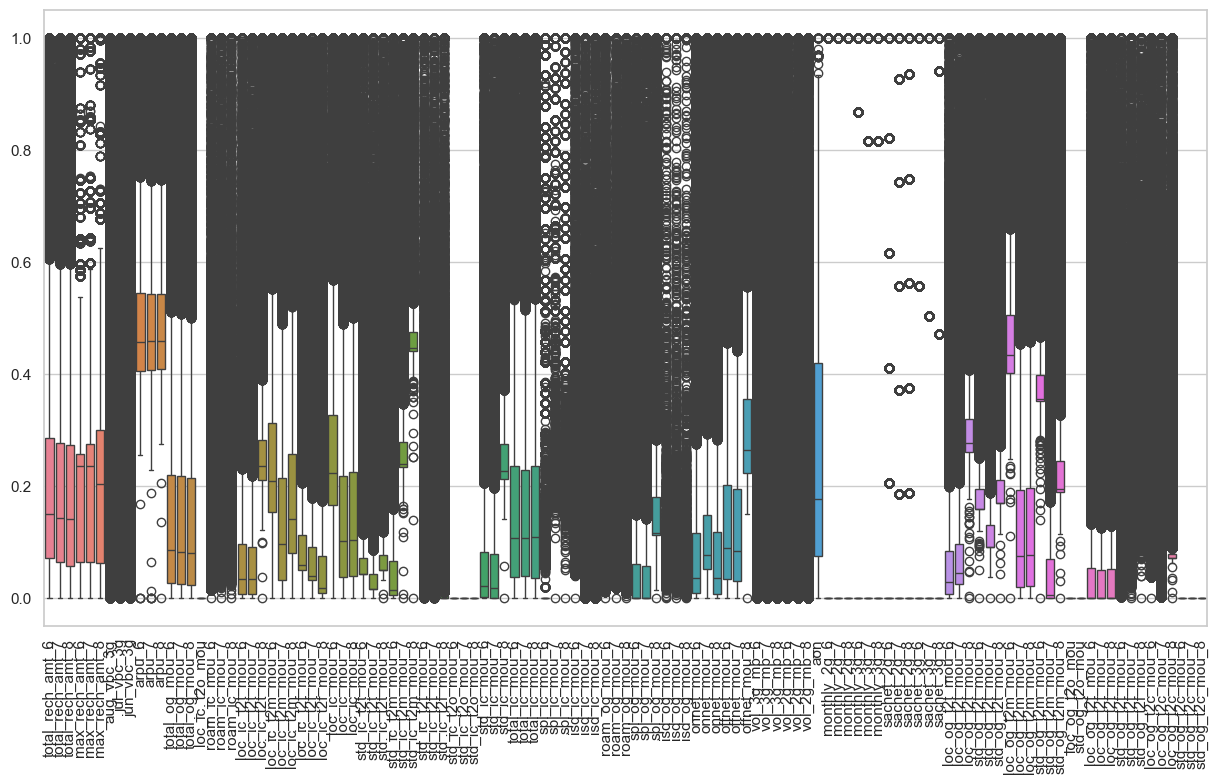

In [54]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data=data_f2_s)
plt.show()

In [55]:
print("Skewness:", data_f2_s.skew())

Skewness: total_rech_amt_6    1.709271
total_rech_amt_7    1.750597
total_rech_amt_8    1.759882
max_rech_amt_6      1.768751
max_rech_amt_7      1.704075
                      ...   
loc_og_t2c_mou_7    4.572306
loc_og_t2c_mou_8    4.042153
std_og_t2c_mou_6    0.000000
std_og_t2c_mou_7    0.000000
std_og_t2c_mou_8    0.000000
Length: 115, dtype: float64


In [56]:
pt = PowerTransformer(method='yeo-johnson')
data_f2_s = pd.DataFrame(
    pt.fit_transform(data_f2_s),  # The transformed array
    columns=data_f2_s.columns,   # Use the original column names
    index=data_f2_s.index        # Retain the original index
)

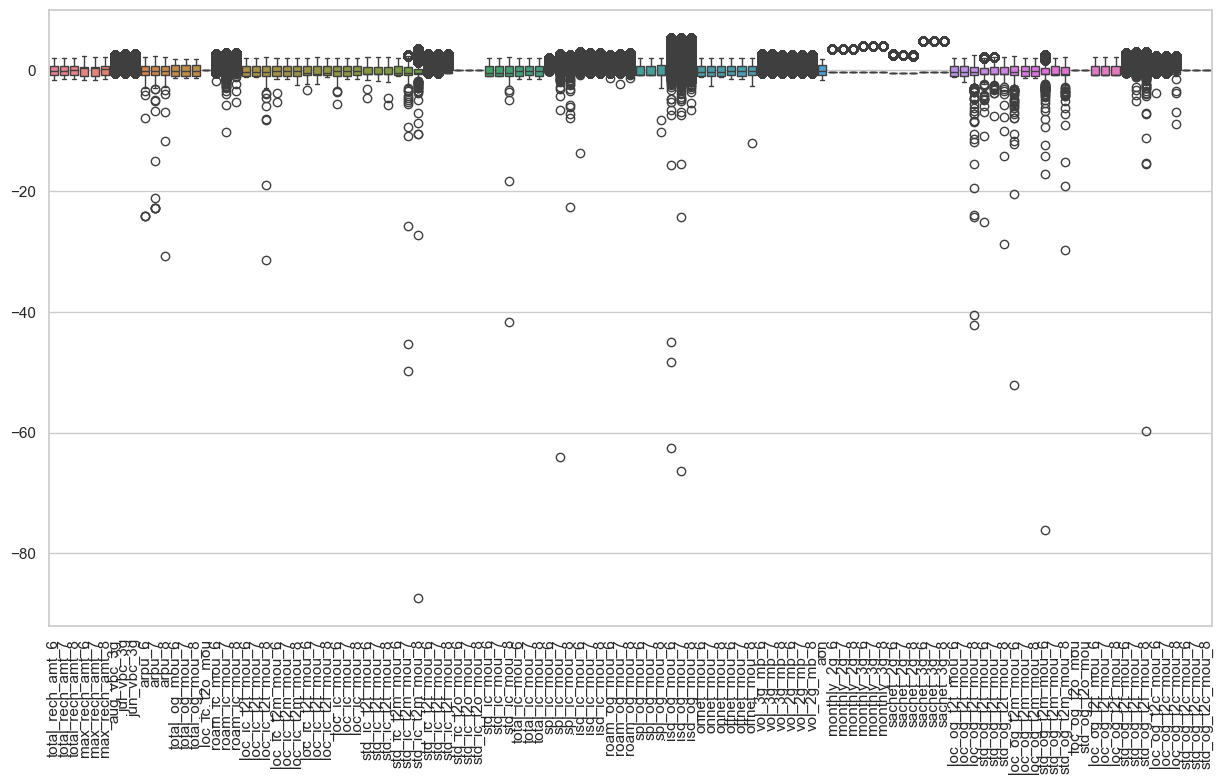

In [57]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data=data_f2_s)
plt.show()

In [58]:
data_f2_s.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
0         -0.931192         -0.981229         -1.385830       -0.239704   
1         -1.544576         -0.449717         -1.071322       -1.626314   
2         -0.981727         -0.603635         -1.470029       -0.157859   
3         -0.398747          0.051441         -0.535211        0.405692   
4          0.237939         -0.503949         -0.583894       -0.503291   

   max_rech_amt_7  max_rech_amt_8  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0       -0.217542       -1.258527   -0.417995    -0.40866   -0.395438   
1        0.791597       -0.484033   -0.417995    -0.40866   -0.395438   
2       -0.137500       -1.488798   -0.417995    -0.40866   -0.395438   
3        0.413702       -0.484033   -0.417995    -0.40866   -0.395438   
4       -0.643831       -0.844541   -0.417995    -0.40866   -0.395438   

     arpu_6  ...  loc_og_t2f_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
0 -1.269558  ...         -0.703932         -0.410857         -0.378314   
1 -1.548803  ...         -0.703932         -0.410857         -0.378314   
2 -1.025627  ...         -0.703932         -0.410857         -0.378314   
3 -0.349398  ...         -0.703932          1.270551         -0.378314   
4  0.129291  ...          1.480004         -0.410857         -0.378314   

   std_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0         -0.371268         -0.499919         -0.512890         -0.535463   
1         -0.371268         -0.499919          2.412382          2.353921   
2         -0.371268          2.114339         -0.512890         -0.535463   
3         -0.371268         -0.499919         -0.512890          2.345308   
4         -0.371268         -0.499919          2.410287         -0.535463   

   std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  
0               0.0               0.0               0.0  
1               0.0               0.0               0.0  
2               0.0               0.0               0.0  
3               0.0               0.0               0.0  
4               0.0               0.0               0.0  

[5 rows x 115 columns]

### ___PCA___
___To find the Principle Components for analysis___

In [59]:
pca = PCA(0.9, random_state = 42)
pca_components = pca.fit(data_f2_s)
pca.components_

array([[ 0.14624185,  0.15405277,  0.14246507, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05095645,  0.05911036,  0.04631458, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.0859771 ,  0.10038218,  0.09609463, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02059596, -0.09296647,  0.01402861, ..., -0.        ,
        -0.        , -0.        ],
       [-0.06681397, -0.0355191 , -0.04874602, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09470039,  0.02521373,  0.00195608, ...,  0.        ,
         0.        ,  0.        ]])

<BarContainer object of 47 artists>

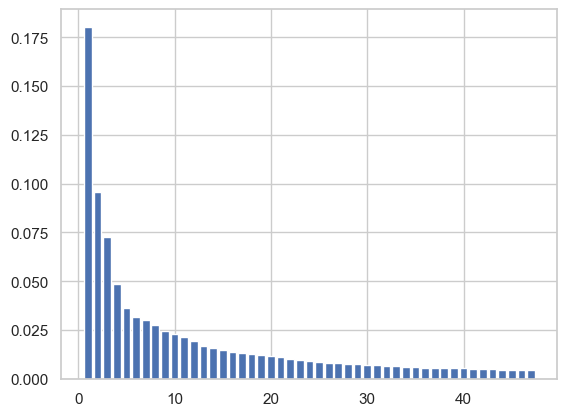

In [60]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)

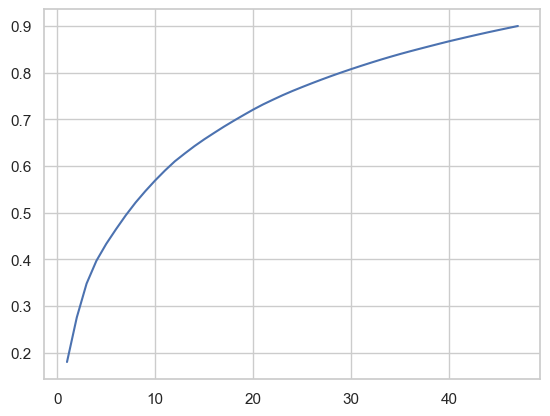

In [61]:
var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cum)+1),var_cum)

Dimensional Reduction 

In [62]:
pca_final = IncrementalPCA(n_components=25)
X_f = pca_final.fit_transform(data_f2_s)

<Axes: >

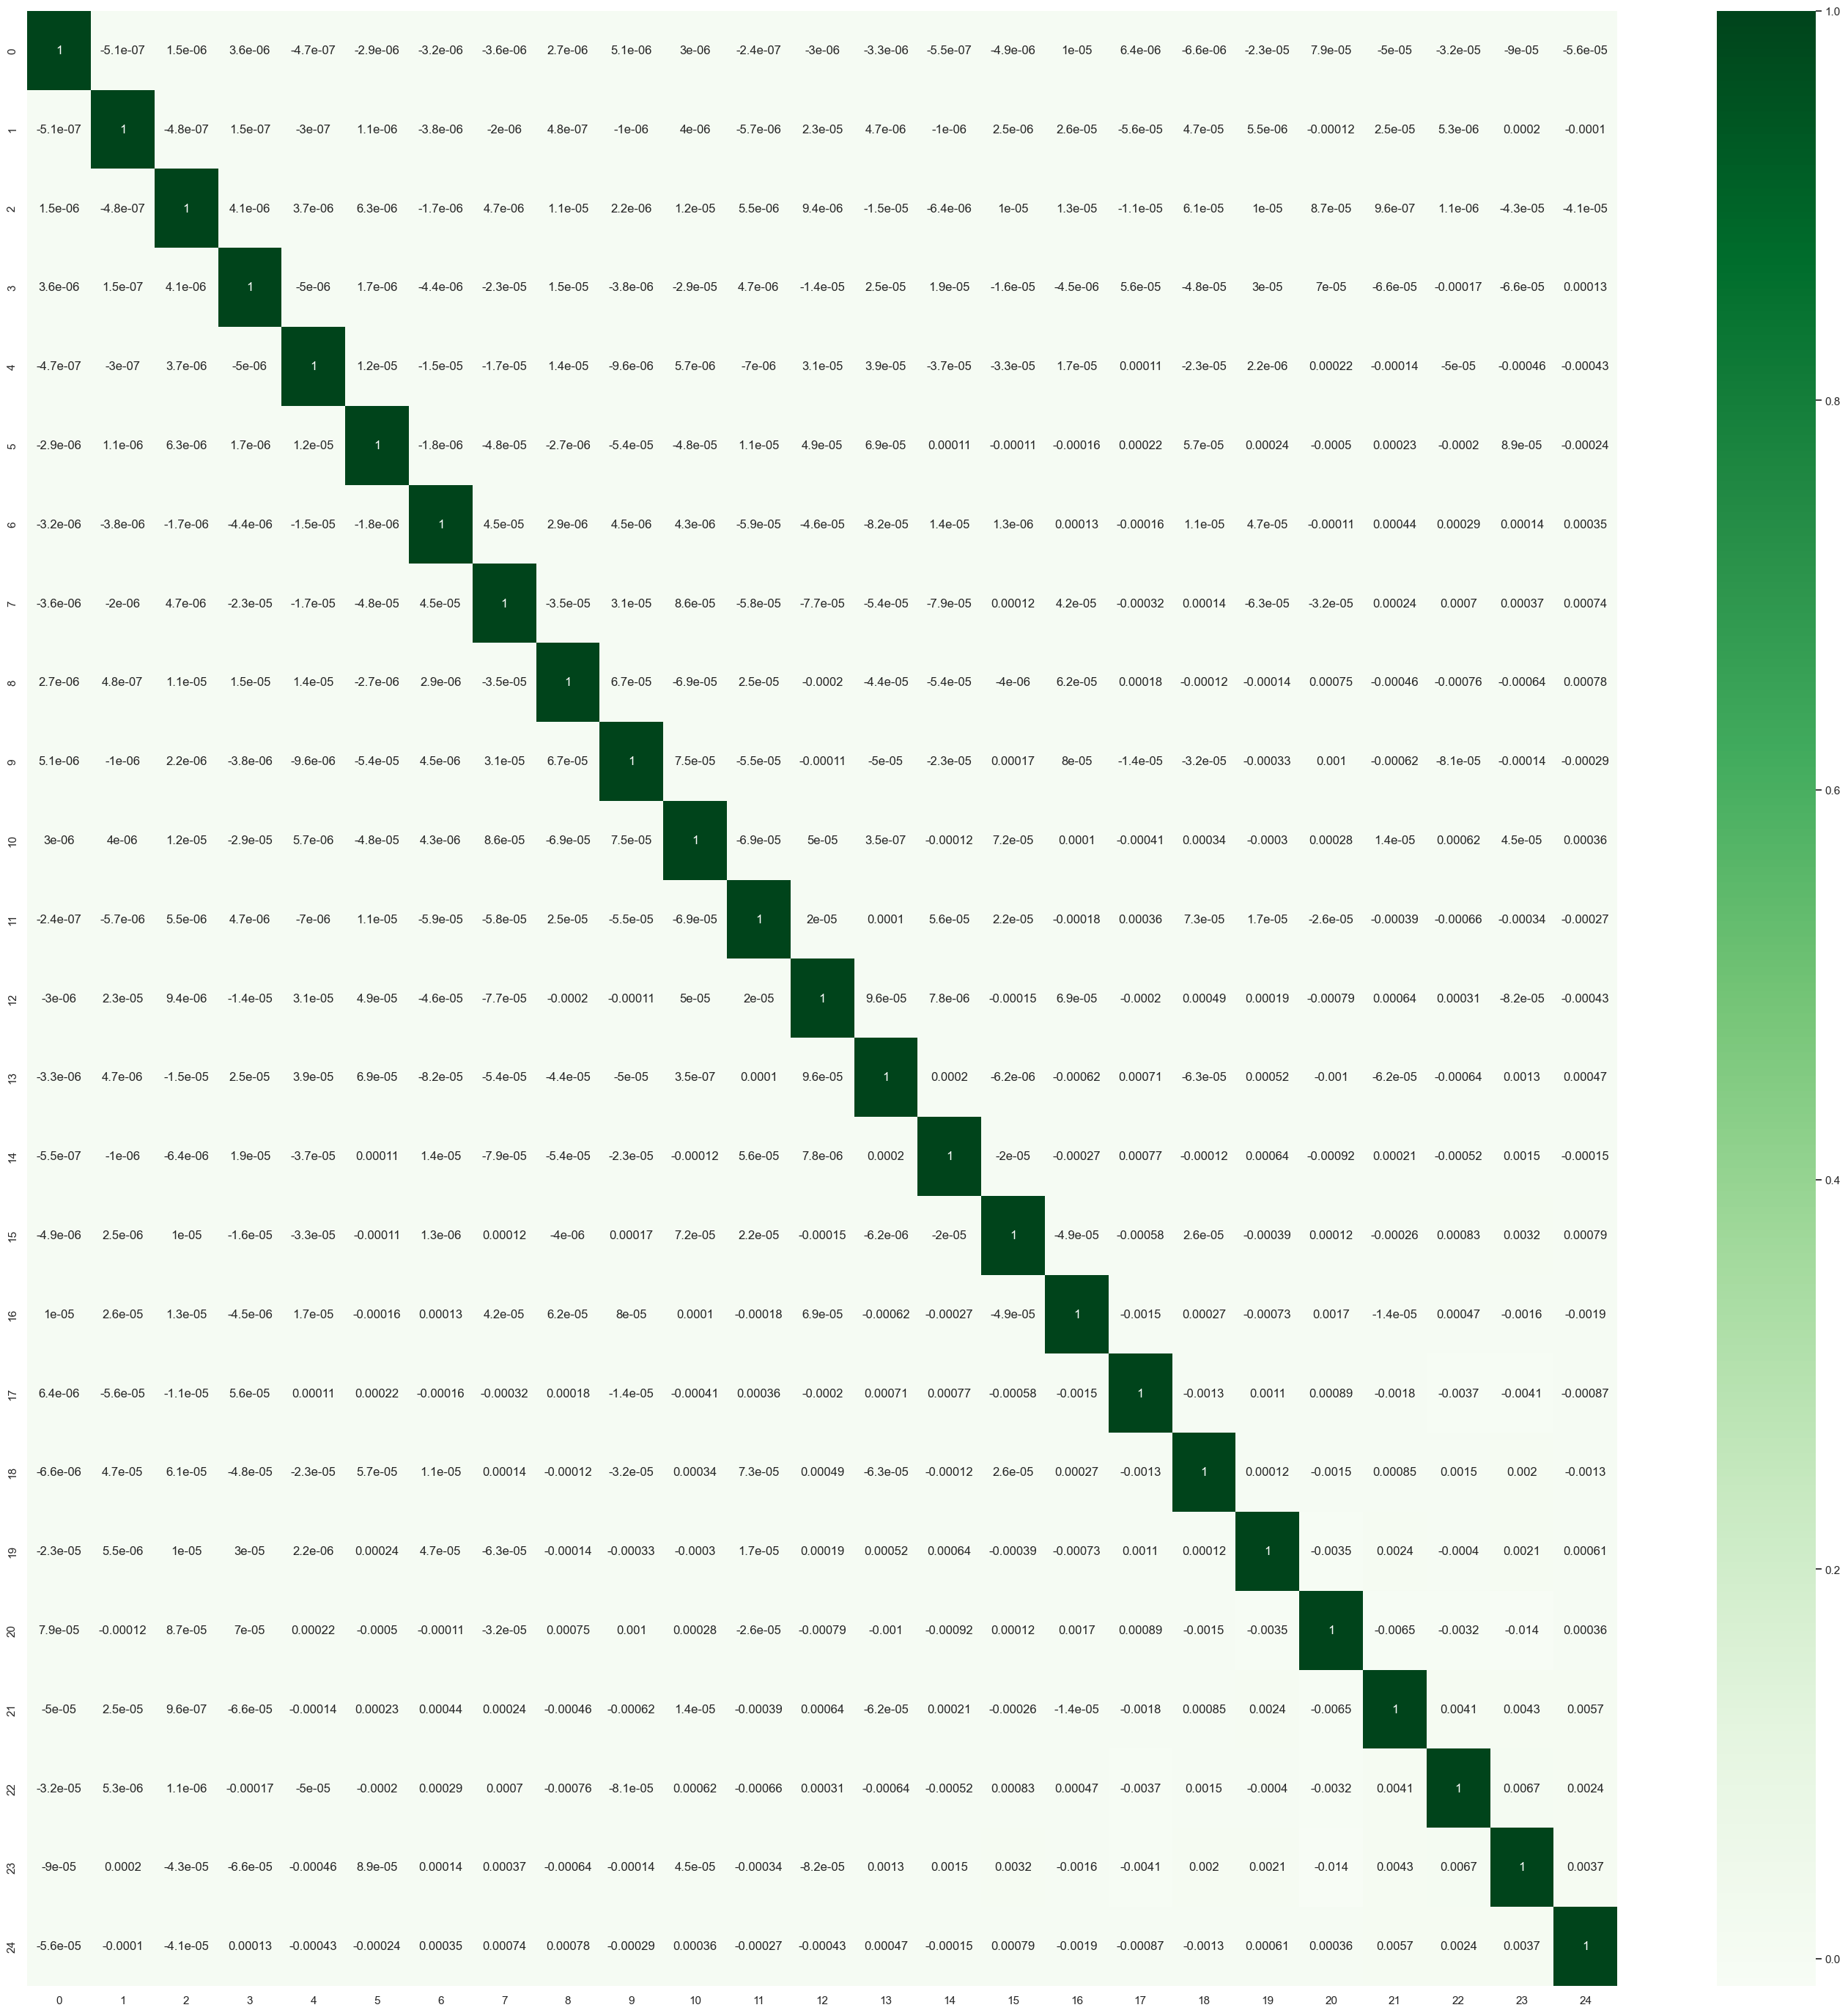

In [63]:
corrmat = np.corrcoef(X_f.transpose())
plt.figure(figsize=[35,35])
sns.heatmap(corrmat, annot=True, cmap='Greens')

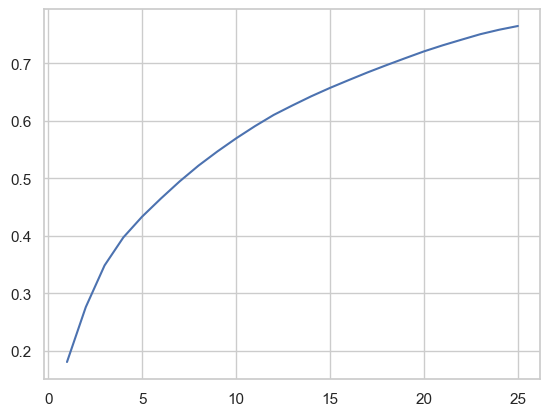

In [64]:
var_cum = np.cumsum(pca_final.explained_variance_ratio_)
plt.plot(range(1,len(var_cum)+1),var_cum)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 25), (14000, 25), (55999,), (14000,))

### ___SMOTE to oversample the minority class in the training data.___

In [66]:
# Apply SMOTE outside the pipeline (since it's not a transformer)
smote = SMOTETomek(sampling_strategy=1.0, random_state=42) #Balances the minority and majority class.

# Perform SMOTE on training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [67]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 50289, 1: 5710})
After SMOTE: Counter({0: 50270, 1: 50270})


### ___User made Function for easir working___

In [68]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap='Oranges'):
    """
    Plots a heatmap for a confusion matrix.
    
    Parameters:
    - cm: Confusion matrix as a 2x2 array or list.
    - title: Title of the plot (default: 'Confusion Matrix').
    - cmap: Color map for the heatmap (default: 'Oranges').
    
    Returns:
    - None
    """
    # Ensure the confusion matrix is a 2x2 numpy array
    cm_array = np.array(cm).reshape(2, 2)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_array, annot=True, cmap=cmap, fmt='g', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

In [69]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train_resampled, dt_classifier.predict(X_train_resampled)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train_resampled, dt_classifier.predict(X_train_resampled)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

# ___Model Generation___

### ___First Model - Logistic Regression___

In [70]:
lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [71]:
lr_sm = sm.GLM(y_train_resampled,(sm.add_constant(X_train_resampled)), family = sm.families.Binomial())
model = lr_sm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:               100540
Model:                            GLM   Df Residuals:                   100514
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38647.
Date:                Sun, 19 Jan 2025   Deviance:                       77293.
Time:                        01:02:27   Pearson chi2:                 1.21e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4607
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3024      0.012   -106.858      0.000      -1.326      -1.279
x1            -0.2177      0.003    -86.632      0.000      -0.223      -0.213
x2             0.2610      0.003     75.419      0.000       0.254       0.268
x3            -0.0344      0.004     -8.132      0.000      -0.043      -0.026
x4             0.2352      0.004     52.583      0.000       0.226       0.244
x5             0.2963      0.005     57.832      0.000       0.286       0.306
x6             0.5466      0.005    101.152      0.000       0.536       0.557
x7            -0.0106      0.005     -2.015      0.044      -0.021      -0.000
x8            -0.1079      0.006    -18.787      0.000      -0.119      -0.097
x9             0.0161      0.006      2.742      0.006       0.005       0.028
x10            0.0276      0.006      4.283      0.000       0.015       0.040
x11            0.1841      0.008     23.784      0.000       0.169       0.199
x12            0.0620      0.009      7.122      0.000       0.045       0.079
x13            0.0182      0.008      2.176      0.030       0.002       0.035
x14            0.3067      0.007     46.677      0.000       0.294       0.320
x15            0.2317      0.008     30.549      0.000       0.217       0.247
x16           -0.1994      0.009    -22.645      0.000      -0.217      -0.182
x17           -0.2846      0.009    -32.821      0.000      -0.302      -0.268
x18           -0.2356      0.009    -26.309      0.000      -0.253      -0.218
x19           -0.0842      0.008    -10.115      0.000      -0.100      -0.068
x20           -0.1400      0.009    -15.450      0.000      -0.158      -0.122
x21           -0.2157      0.010    -22.698      0.000      -0.234      -0.197
x22           -0.2217      0.010    -21.373      0.000      -0.242      -0.201
x23           -0.0832      0.010     -8.196      0.000      -0.103      -0.063
x24           -0.0665      0.011     -6.284      0.000      -0.087      -0.046
x25           -0.2173      0.012    -17.434      0.000      -0.242      -0.193
==============================================================================
"""

In [72]:
lr.score(X_train_resampled, y_train_resampled)

0.8439228167893376

In [73]:
# Calculate accuracy
accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f"Accuracy of Logistic Regression model: {accuracy:.2f}")


Accuracy of Logistic Regression model: 0.85


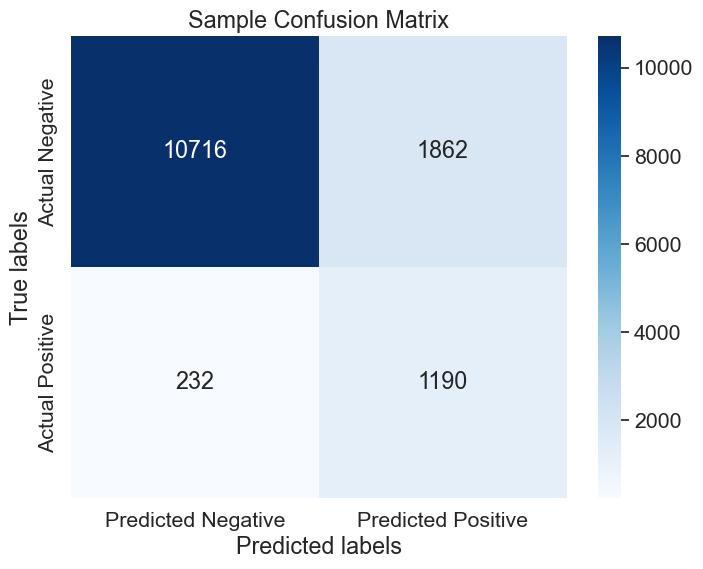

In [74]:
# Compute confusion matrix
cm = confusion_matrix(y_test, lr.predict(X_test))

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

#### ___Hyperparameter Tuning For Logistic Regression___

In [75]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],                     # Regularization penalty
    'C': [0.1, 1, 10],                    # Regularization strength
    'solver': ['lbfgs', 'liblinear'],      # Optimization solver
    'max_iter': [100, 200],                # Maximum number of iterations
    'fit_intercept': [True, False],        # Whether to include an intercept term
    'class_weight': [None, 'balanced'],    # Weights for classes
}

# Create the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Create a KFold cross-validation object
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',  # Scoring metric
    cv=folds,            # 5-fold cross-validation
    n_jobs=-1,           # Use all cores for parallelism
    verbose=2            # Show progress
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Best score from cross-validation
print("Best cross-validated accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train_resampled)
test_accuracy = accuracy_score(y_train_resampled, y_pred)
print("Test accuracy:", test_accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy: 0.8439327630793713
Test accuracy: 0.8439128704993037


#### ___First Pipeline___

In [76]:
imp = IterativeImputer(max_iter=10, random_state=42,n_nearest_features=5,initial_strategy='median')
scale = MinMaxScaler()
lr = LogisticRegression(C=1, class_weight='balanced', fit_intercept=True, max_iter=100, penalty='l2', solver= 'liblinear',random_state=42)

In [77]:
pipe_1 = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('model',lr)])

In [78]:
pipe_1.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median',
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [79]:
evaluate_model(pipe_1)

Train Accuracy : 0.8437039984085936
Train Confusion Matrix:
[[42997  7273]
 [ 8441 41829]]
--------------------------------------------------
Test Accuracy : 0.8500714285714286
Test Confusion Matrix:
[[10714  1864]
 [  235  1187]]


In [80]:
recall_score(y_test, pipe_1.predict(X_test))

0.8347398030942335

In [81]:
f1_score(y_test, pipe_1.predict(X_test))

0.530739995528728

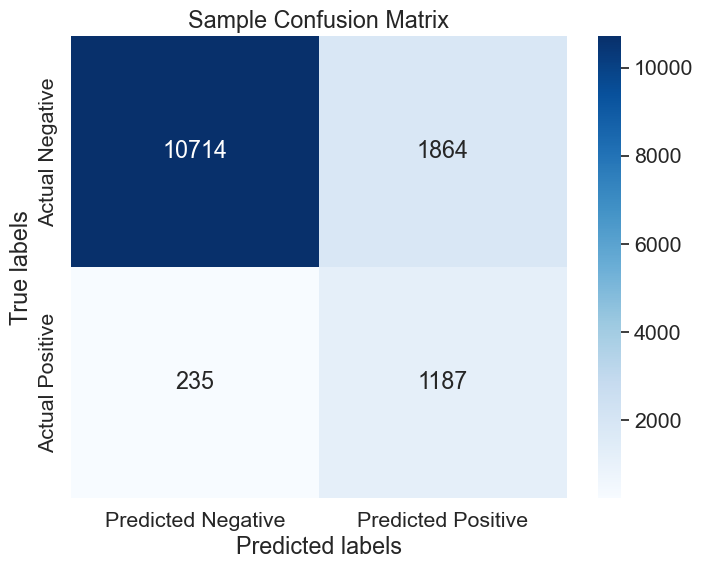

In [82]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pipe_1.predict(X_test))

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

### ___Second Model - Random Forest Classifier___

In [83]:
# Using Random Forest 
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1)

In [84]:
y_pred = rf.predict(X_test)

In [85]:
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.9227857142857143


array([[11937,   641],
       [  440,   982]], dtype=int64)

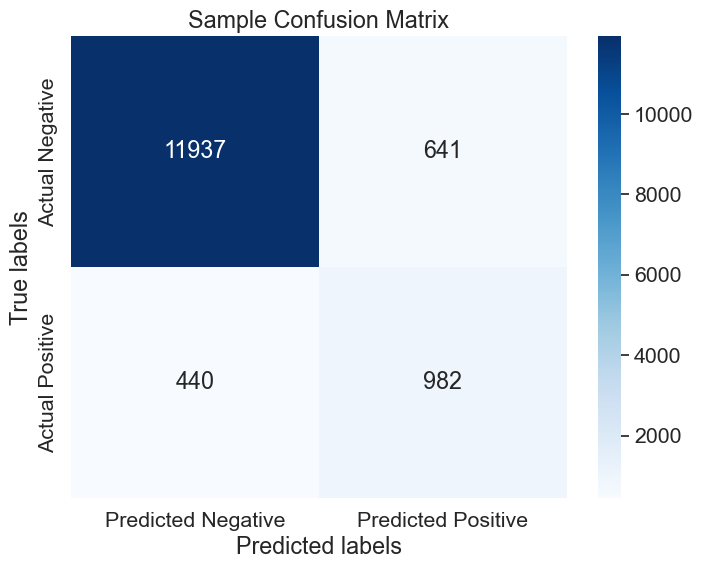

In [86]:
# Compute confusion matrix
cm = confusion_matrix(y_test,rf.predict(X_test))

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

#### ___Hyperparameter tuning___

In [87]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [20, 50, 10],              # Number of trees
    'max_depth': [10, 20, 30],              # Depth of trees
    'min_samples_split': [5, 10],                  # Minimum samples to split a node
    'min_samples_leaf': [2, 4],                    # Minimum samples in a leaf
    'bootstrap': [True, False],                       # Bootstrap sampling
    'random_state': [42]                              # Random state for reproducibility
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings to sample
    scoring='accuracy',  # Evaluation metric
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Evaluate on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'random_state': 42, 'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Best cross-validation accuracy: 0.9419634106996493
Test accuracy: 0.919


#### ___Pipeline 2 For RandomForestClassifier___

In [88]:
imp2 = IterativeImputer(max_iter=20, random_state=42  , n_nearest_features=5,initial_strategy='median')
scale2 = MinMaxScaler()
ad = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_depth=30, bootstrap=False, n_jobs=-1)


In [89]:
# Define the pipeline using scikit-learn's pipeline
pipe2 = Pipeline(steps=[('imputation', imp2),  # Imputation
                        ('scaling', scale2),  # Scaling
                        ('model', ad)  # AdaBoostClassifier
                        ])
     # Fit GridSearchCV on resampled data
pipe2.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median', max_iter=20,
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=30,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42))])

In [90]:
pipe2.score(X_train_resampled, y_train_resampled)

0.997772031032425

In [91]:
recall_score(y_test, pipe2.predict(X_test))

0.6511954992967651

In [92]:
f1_score(y_test, pipe2.predict(X_test))

0.6204355108877722

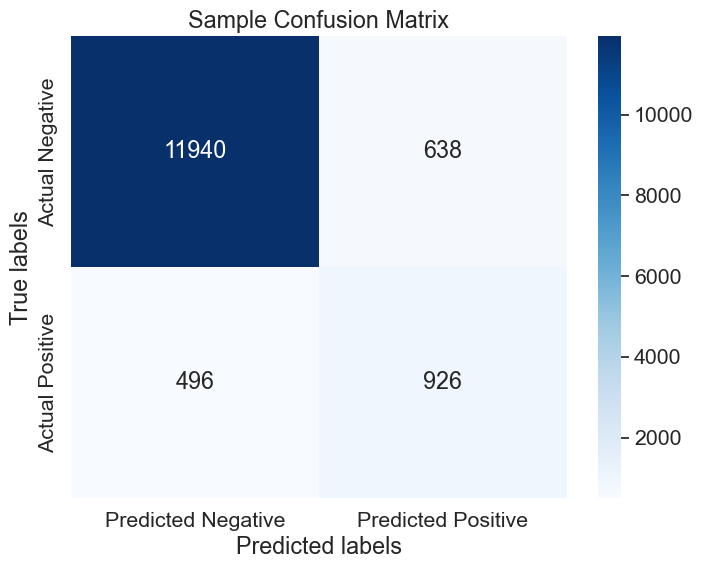

In [93]:
# Compute confusion matrix
cm = confusion_matrix(y_test,pipe2.predict(X_test))

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

### ___Third Model - Adaboost Classification___

##### ___Basic Ada Boost___

In [94]:
# Define AdaBoost classifier with a base decision tree estimator
adaboost_clf = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1),random_state=42, n_estimators = 50)

adaboost_clf.fit(X_train_resampled, y_train_resampled)

y_pred = adaboost_clf.predict(X_test)

In [95]:
print('Accuracy of the model is:  ',accuracy_score(y_test, y_pred))

Accuracy of the model is:   0.8418571428571429


In [96]:
recall_score(y_test, y_pred)

0.8023909985935302

In [97]:
f1_score(y_test, y_pred)

0.5075622775800712

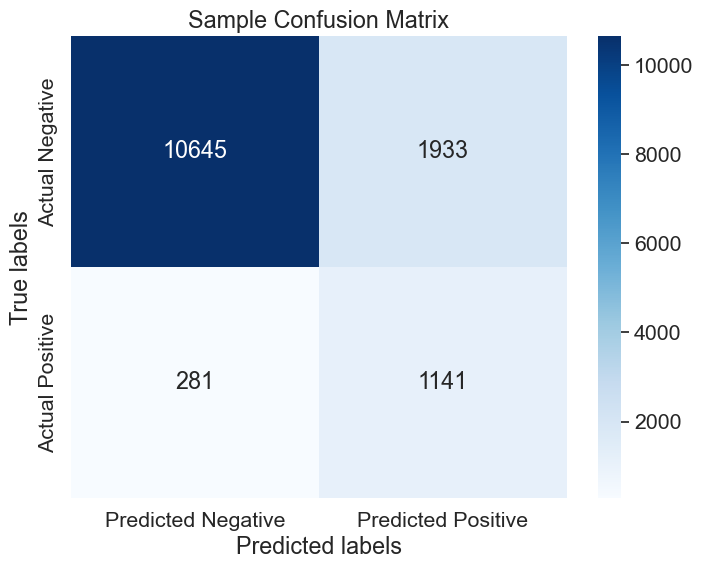

In [98]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

#### ___Hyperparameter Tuning for AdaBoost___

In [99]:
# Define AdaBoost classifier with a base decision tree estimator
adaboost_clf = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1),random_state=42)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],  # Fewer options
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Key values for learning rate
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=adaboost_clf,
    param_distributions=param_distributions,
    n_iter=50,  # Only test 50 combinations
    scoring='accuracy',  # Use accuracy_score score for evaluation
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV on a subset of data (optional for tuning)
sample_size = 10000  # Use a smaller sample size for faster tuning
X_train_sampled = X_train_resampled[:sample_size]
y_train_sampled = y_train_resampled[:sample_size]

random_search.fit(X_train_sampled, y_train_sampled)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Evaluate on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'n_estimators': 150, 'learning_rate': 1.0}
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     12578
           1       0.65      0.44      0.53      1422

    accuracy                           0.92     14000
   macro avg       0.80      0.71      0.74     14000
weighted avg       0.91      0.92      0.91     14000



#### ___Pipeline 3 For Adaboost Classification___

In [100]:
imp3 = IterativeImputer(max_iter=20, random_state=42  , n_nearest_features=5,initial_strategy='median')
scale3 = MinMaxScaler()
ad = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), n_estimators= 150, learning_rate=1, random_state=42)

In [101]:
# Define the pipeline using scikit-learn's pipeline
pipe3 = Pipeline(steps=[('imputation', imp3),  # Imputation
                        ('scaling', scale3),  # Scaling
                        ('model', ad)  # AdaBoostClassifier
                        ])
pipe3.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('imputation',
                 IterativeImputer(initial_strategy='median', max_iter=20,
                                  n_nearest_features=5, random_state=42)),
                ('scaling', MinMaxScaler()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=1, n_estimators=150,
                                    random_state=42))])

In [102]:
y_pred = pipe3.predict(X_test)

In [103]:
pipe3.score(X_train_resampled, y_train_resampled)

0.8357569126715735

In [104]:
recall_score(y_test, pipe3.predict(X_test))

0.819971870604782

In [105]:
f1_score(y_test, pipe3.predict(X_test))

0.5080610021786492

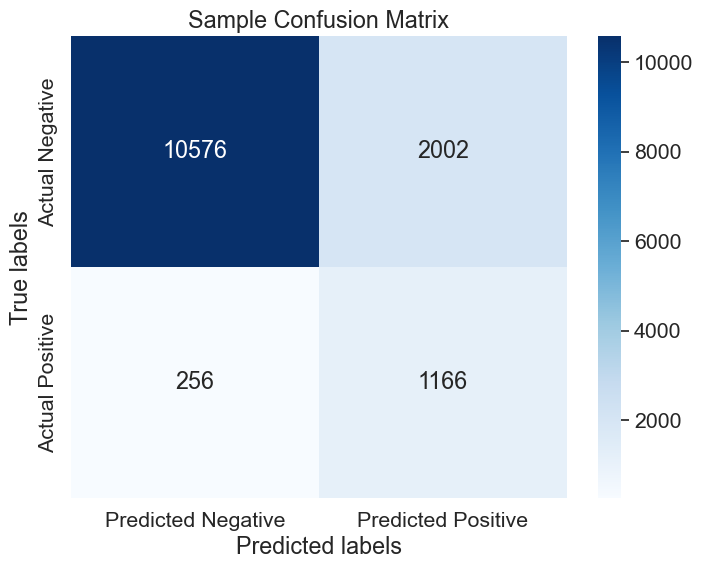

In [106]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pipe3.predict(X_test))

# Call the function to plot
plot_confusion_matrix(cm, title='Sample Confusion Matrix', cmap='Blues')

# ___Final Model Scores___

In [107]:
def evaluate_models(pipes, X_train_resampled, y_train_resampled, X_test, y_test):
    """
    Evaluate the performance of multiple pipelines/models on training and test datasets.

    Parameters:
        pipes (dict): Dictionary with pipeline names as keys and pipeline objects as values.
        X_train (DataFrame): Training feature set.
        y_train (Series): Training target variable.
        X_test (DataFrame): Testing feature set.
        y_test (Series): Testing target variable.

    Returns:
        None. Prints metrics for each pipeline.
    """
    for name, pipe in pipes.items():
        print(f"Evaluating {name}...\n")
        
        # Training Predictions
        y_train_pred = pipe.predict(X_train_resampled)
        y_train_proba = pipe.predict_proba(X_train_resampled)[:, 1]  # For ROC-AUC
        
        # Test Predictions
        y_test_pred = pipe.predict(X_test)
        y_test_proba = pipe.predict_proba(X_test)[:, 1]  # For ROC-AUC
        
        # Training Metrics
        print("Training Metrics:")
        print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
        print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
        print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
        print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
        print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
        
        # Test Metrics
        print("\nTest Metrics:")
        print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
        print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
        print("-" * 80)

In [108]:
# Define your pipelines/models
pipes = {
    "Pipe1": pipe_1,
    "Pipe2": pipe2,
    "Pipe3": pipe3
}

# Call the function with datasets and pipelines
evaluate_models(pipes, X_train, y_train, X_test, y_test)


Evaluating Pipe1...

Training Metrics:
Accuracy: 0.8510
Precision: 0.3897
Recall: 0.8149
F1 Score: 0.5273
ROC-AUC: 0.8976
Confusion Matrix:
 [[43003  7286]
 [ 1057  4653]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91     50289
           1       0.39      0.81      0.53      5710

    accuracy                           0.85     55999
   macro avg       0.68      0.84      0.72     55999
weighted avg       0.92      0.85      0.87     55999


Test Metrics:
Accuracy: 0.8501
Precision: 0.3891
Recall: 0.8347
F1 Score: 0.5307
ROC-AUC: 0.9064
Confusion Matrix:
 [[10714  1864]
 [  235  1187]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91     12578
           1       0.39      0.83      0.53      1422

    accuracy                           0.85     14000
   macro avg       0.68      0.84      0.72     14000
weighted avg       0.92      0.

### ___Analysis___

Pipe2 has an exceptionally high training accuracy (99.76%), but there is a significant drop in performance on the test set, especially with precision and recall. This suggests that overfitting may be occurring (i.e., the model performs well on training data but struggles with generalization on unseen test data).

Pipe1 has balanced performance between training and testing accuracy (around 74-75%). However, its precision is low, meaning it predicts many false positives. The recall is better, capturing many positives (with a recall of around 0.79), but the F1 score reflects an imbalance between precision and recall.

Pipe3 has moderate performance with test accuracy around 78.81%, which is better than Pipe1 but lower than Pipe2. Its precision and recall are slightly better than Pipe1's, with F1 scores indicating it strikes a better balance between the two.

### ___Which is the Better Model?___

Pipe2 performs exceptionally well on the training set (near-perfect), but due to a significant drop in precision and recall on the test set, it seems overfitted. The model does well in remembering the training data but fails to generalize to unseen data.

Pipe3 provides more stable performance between training and testing, with higher precision and recall compared to Pipe1. Its F1 score is also better, and it seems to balance false positives and false negatives better than Pipe1.

Pipe1 has the lowest performance overall, especially considering the F1 score.

### ___Conclusion:___

Best Overall Model: Pipe3, as it strikes a better balance between precision, recall, and generalization.

Pipe2 might be ideal for scenarios where performance on the training set is more critical, but its overfitting makes it less reliable for deployment on unseen data.
If the goal is to focus on minimizing false positives and false negatives in your specific application, Pipe3 would likely be the best choice.

# ___Creating Submission File___

In [109]:
unseen_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [110]:
unseen_df.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=171)

#### ___Feature Selection and alteration___

In [111]:
# Identifying key variables based on descriptions
ids = ['id', 'circle_id']

# Adding revenue and amount-related variables
total_amounts = [i for i in list(unseen_df.columns) if re.search('total.+amt', i)]
recharge_amounts = [i for i in list(unseen_df.columns) if re.search('rech.+amt', i)]
vbc_costs = [i for i in list(unseen_df.columns) if re.search('vbc', i)]
arpu_values = [i for i in list(unseen_df.columns) if re.search('arpu', i)]

# Call usage variables
total_outgoing_minutes = [i for i in list(unseen_df.columns) if re.search('total.+og.+mou', i)]
incoming_minutes = [i for i in list(unseen_df.columns) if re.search('ic.+mou', i)]
roaming_minutes = [i for i in list(unseen_df.columns) if re.search('roam.+mou', i)]
special_call_minutes = [i for i in list(unseen_df.columns) if re.search('spl.+mou', i)]
isd_call_minutes = [i for i in list(unseen_df.columns) if re.search('isd.+mou', i)]

# On-net and off-net variables
onnet_minutes = [i for i in list(unseen_df.columns) if re.search('onnet.+mou', i)]
offnetwork_minutes = [i for i in list(unseen_df.columns) if re.search('offnet.+mou', i)]

# Internet usage variables
volume_3g = [i for i in list(unseen_df.columns) if re.search('vol.+3g', i)]
volume_2g = [i for i in list(unseen_df.columns) if re.search('vol.+2g', i)]
average_revenue_3g = [i for i in list(unseen_df.columns) if re.search('arpu.+3g', i)]
average_revenue_2g = [i for i in list(unseen_df.columns) if re.search('arpu.+2g', i)]

# Age and scheme-related variables
age_on_network = [i for i in list(unseen_df.columns) if re.search('aon', i)]
night_usage = [i for i in list(unseen_df.columns) if re.search('night', i)]
monthly_schemes = [i for i in list(unseen_df.columns) if re.search('monthly', i)]
sachet_schemes = [i for i in list(unseen_df.columns) if re.search('sachet', i)]
fb_user = [i for i in list(unseen_df.columns) if re.search('fb_user', i)]

# Call type-specific usage
t2t_calls = [i for i in list(unseen_df.columns) if re.search('t2t', i)]
t2m_calls = [i for i in list(unseen_df.columns) if re.search('t2m', i)]
t2o_calls = [i for i in list(unseen_df.columns) if re.search('t2o', i)]
t2f_calls = [i for i in list(unseen_df.columns) if re.search('t2f', i)]
t2c_calls = [i for i in list(unseen_df.columns) if re.search('t2c', i)]

# KPIs for specific months
monthly_kpis = [i for i in list(unseen_df.columns) if re.search(r'\.\d+', i)]

# Storing them in a single flat list
variables = [
    *ids,
    *total_amounts,
    *recharge_amounts,
    *vbc_costs,
    *arpu_values,
    *total_outgoing_minutes,
    *incoming_minutes,
    *roaming_minutes,
    *special_call_minutes,
    *isd_call_minutes,
    *onnet_minutes,
    *offnetwork_minutes,
    *volume_3g,
    *volume_2g,
    *average_revenue_3g,
    *average_revenue_2g,
    *age_on_network,
    *night_usage,
    *monthly_schemes,
    *sachet_schemes,
    *fb_user,
    *t2t_calls,
    *t2m_calls,
    *t2o_calls,
    *t2f_calls,
    *t2c_calls,
    *monthly_kpis,
]

# Selecting the relevant subset of data
unseen_dfn = unseen_df[variables].set_index('id')


In [112]:
unseen_dfn.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                       
69999        109               103                90                60   
70000        109               500               500               500   
70001        109               500              1000              1000   
70002        109               110               260                 0   
70003        109               356               490               546   

       total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
id                                                                            
69999               103                90                60              50   
70000               500               500               500             250   
70001               500              1000              1000             300   
70002               110               260                 0             110   
70003               356               490               546              90   

       max_rech_amt_7  max_rech_amt_8  ...  loc_ic_t2f_mou_8  \
id                                     ...                     
69999              30              30  ...              0.00   
70000             250             250  ...              0.00   
70001             500             500  ...              0.00   
70002             150               0  ...              1.64   
70003             130             130  ...              0.00   

       std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_t2f_mou_8  loc_og_t2c_mou_6  \
id                                                                              
69999               0.0               0.0              0.00               0.0   
70000               0.0               0.0              0.00               0.0   
70001               0.0               0.0              0.00               0.0   
70002               0.0               0.0              0.00               0.0   
70003               0.0               0.0              1.61               0.0   

       loc_og_t2c_mou_7  loc_og_t2c_mou_8  std_og_t2c_mou_6  std_og_t2c_mou_7  \
id                                                                              
69999              0.00              0.03               0.0               0.0   
70000              0.00              0.00               0.0               0.0   
70001              0.00              0.00               0.0               0.0   
70002              6.18              0.00               0.0               0.0   
70003              0.00              0.00               0.0               0.0   

       std_og_t2c_mou_8  
id                       
69999               0.0  
70000               0.0  
70001               0.0  
70002               0.0  
70003               0.0  

[5 rows x 171 columns]

In [113]:
# Drop duplicate columns based on their headers
unseen_dfn = unseen_dfn.loc[:, ~unseen_dfn.columns.duplicated()]

In [114]:
new_vars = new_vars.drop('circle_id', 1)[:-1]
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'arpu_6',
       ...
       'loc_og_t2f_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8'],
      dtype='object', length=115)

In [115]:
unseen_f = unseen_dfn[new_vars]

In [116]:
unseen_dfn.shape, unseen_f.shape, X_train_resampled.shape

((30000, 131), (30000, 115), (100540, 25))

In [117]:
# 1. Impute missing values in unseen data using the same imputer applied to training data
unseen_f_imputed = mice_imputer.transform(unseen_f[impute_cols])  # Apply IterativeImputer to unseen data
unseen_f[impute_cols] = unseen_f_imputed  # Store imputed data back into the unseen data frame

# 2. Scale the unseen data using the same MinMaxScaler applied to the training data
unseen_f_scaled = scaler.transform(unseen_f)  # Apply the MinMaxScaler to unseen data

# 3. Apply Power Transformation to the unseen data (Yeo-Johnson method)
unseen_f_transformed = pt.transform(unseen_f_scaled)  # Apply PowerTransformer to unseen data

# 4. Apply PCA transformation to the unseen data (ensure it has the same number of components as training data)
unseen_f_pca = pca_final.transform(unseen_f_transformed)  # Apply PCA transformation to unseen data


In [118]:
unseen_f_pca.shape

(30000, 25)

In [119]:
# AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), n_estimators= 150, learning_rate=1, random_state=42)
y_unseen_pred = pipe3.predict(unseen_f_pca)

In [120]:
y_unseen_pred

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [121]:
unseen_df['churn_probability'] = y_unseen_pred


In [122]:
# Set the 'id' column as the index for the output DataFrame
output = unseen_df[['id', 'churn_probability']].reset_index(drop=True)  # Select 'id' and 'churn_probability' columns
output.set_index('id', inplace=True)  # Set 'id' as the index

# Check the result
output.head()


churn_probability
id                      
69999                  0
70000                  0
70001                  1
70002                  0
70003                  0

In [125]:
output.to_csv('submission_pca_adaboost_19Jan.csv')